In [1]:
import pandas as pd
df = pd.read_excel('churn_prediction.xlsx')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

In [3]:
df.head(1)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93



**1: DATA PREPROCSSING**

1.1 Check imbalance data



In [4]:
# Check imbalanced data:
imb_df = df.groupby('Churn')['CustomerID'].count().reset_index()
imb_df['%'] = imb_df['CustomerID']/sum(imb_df['CustomerID'])
imb_df


,Churn,CustomerID,%
0,0,4682,0.831616
1,1,948,0.168384


→ Dữ liệu không bị mất cân bằng nhiều → Chấp nhận

1.2 Handle Values

*1.2.1 Missing values*

<Axes: >

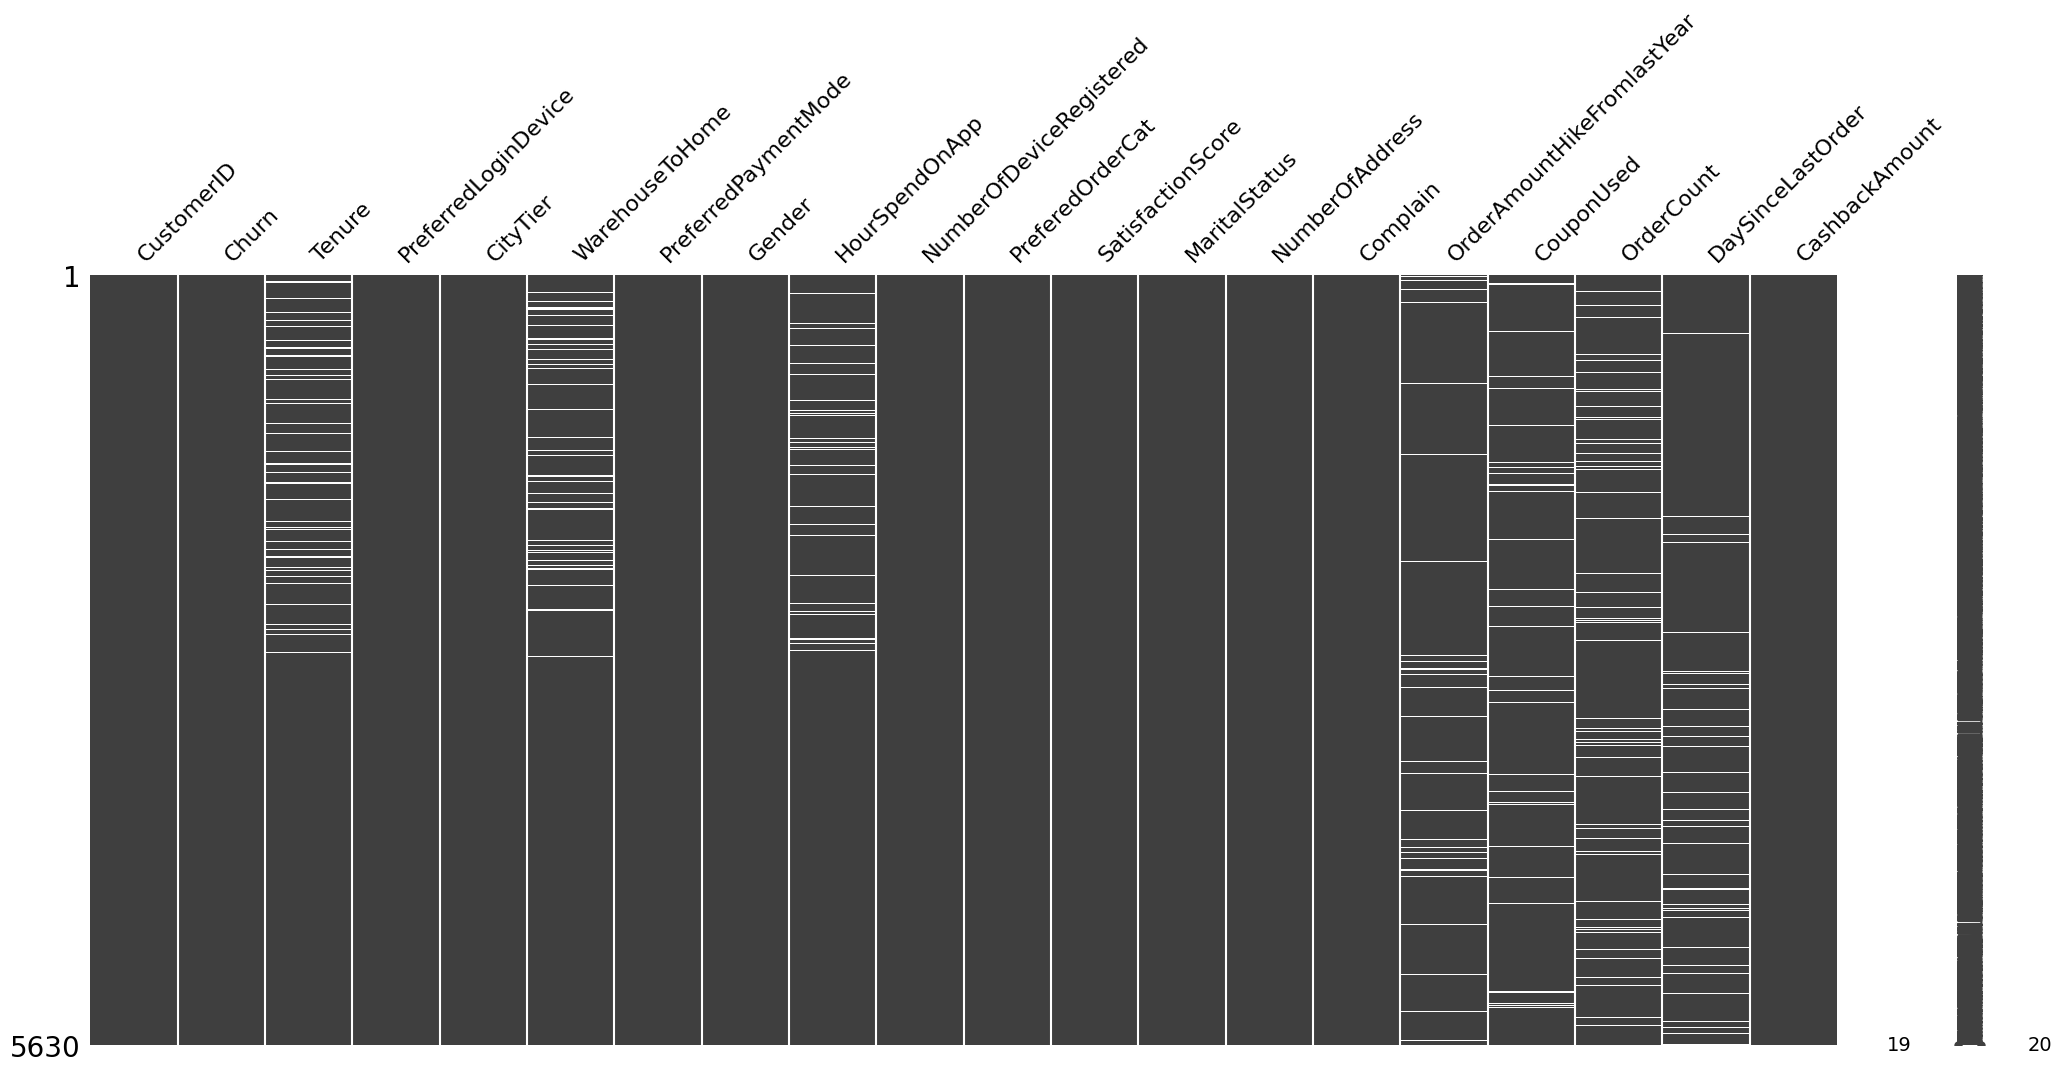

In [5]:
import missingno as msno
msno.matrix(df)

1. Ta có 7 cột bị thiếu giá trị (Tenure, Warehouse To Home, Hour Spend On App, Order Amount Hike From last Year, Counpon Used, Order Count, Day Since Last Order). Số lượng giá trị bị thiếu lớn --> Thay thế bằng giá trị khác

2. Ta cần kiểm tra các cột này là số hay danh mục.
Nếu là số (Numeric values): thay thế bằng mean, median hoặc 0. Nếu là danh mục(category) thay thế bằng mode.
Mean: do not have outliers

*   Mean: do not have outliers
*   Median: can cover outliers
*   0: When the features can have 0 in values



In [6]:
# Check dtypes of columns has missing values:
list_null = df.columns[df.isnull().any()].tolist()
df[list_null].dtypes

Tenure                         float64
WarehouseToHome                float64
HourSpendOnApp                 float64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
dtype: object

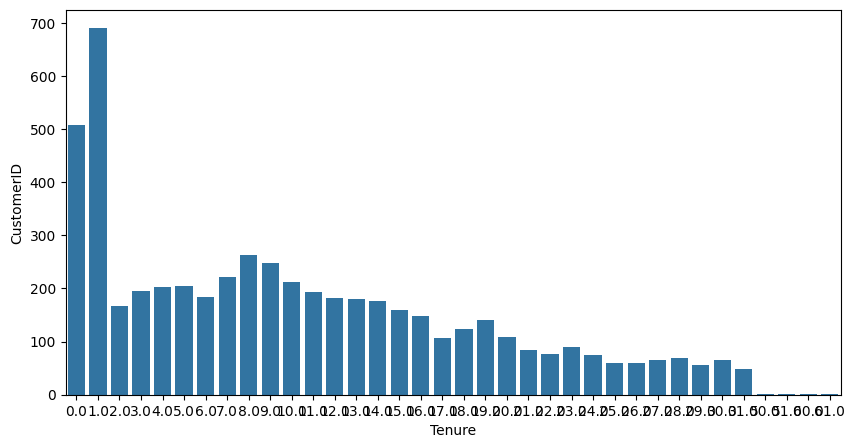

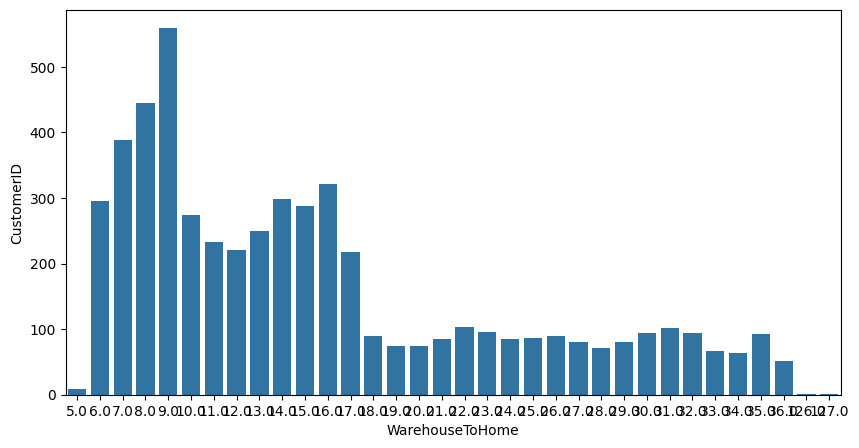

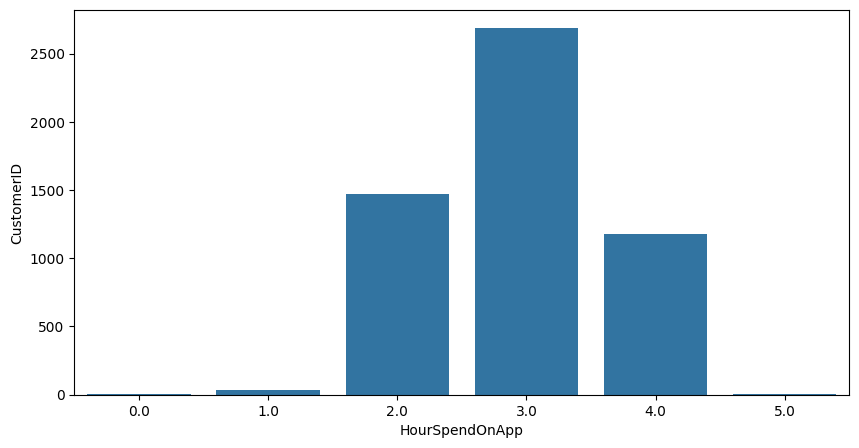

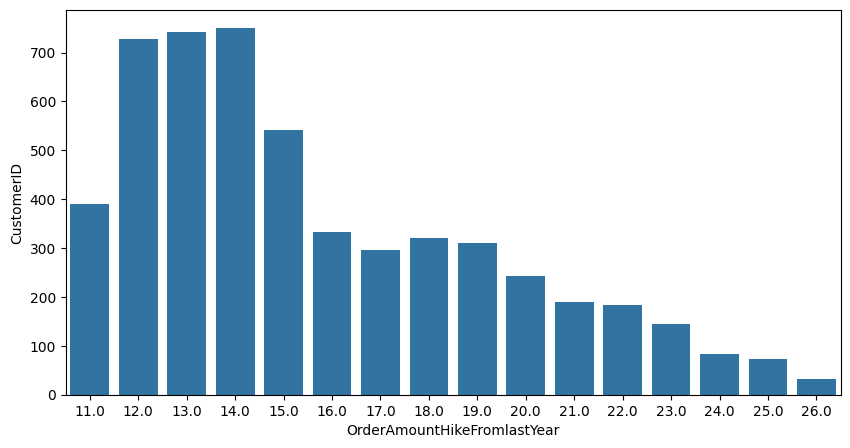

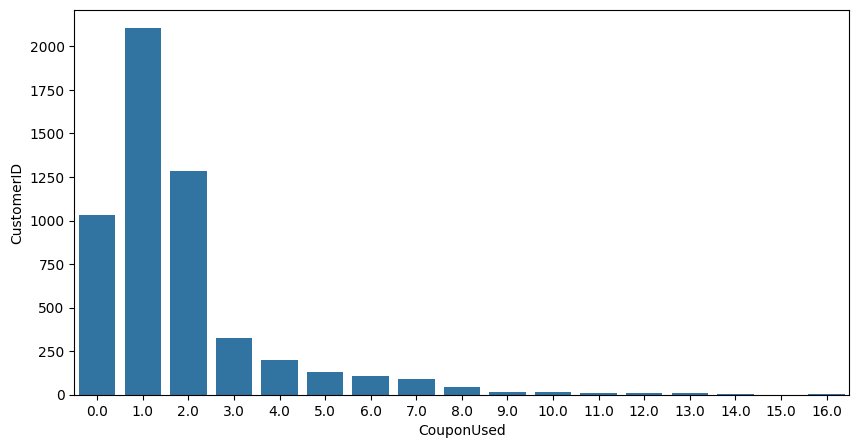

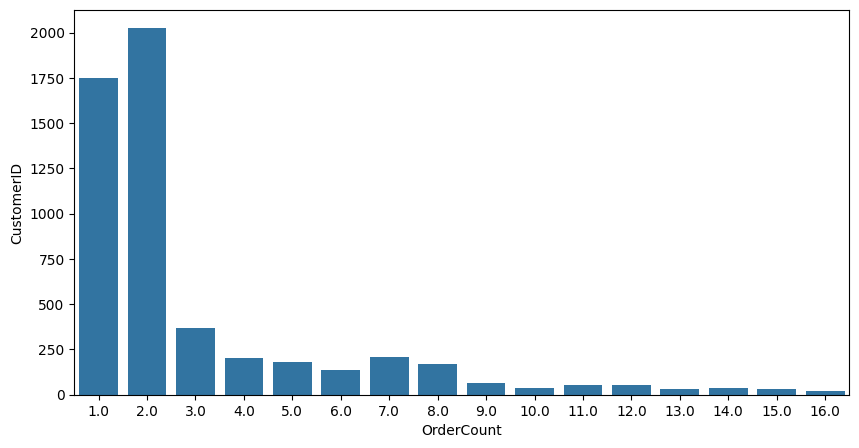

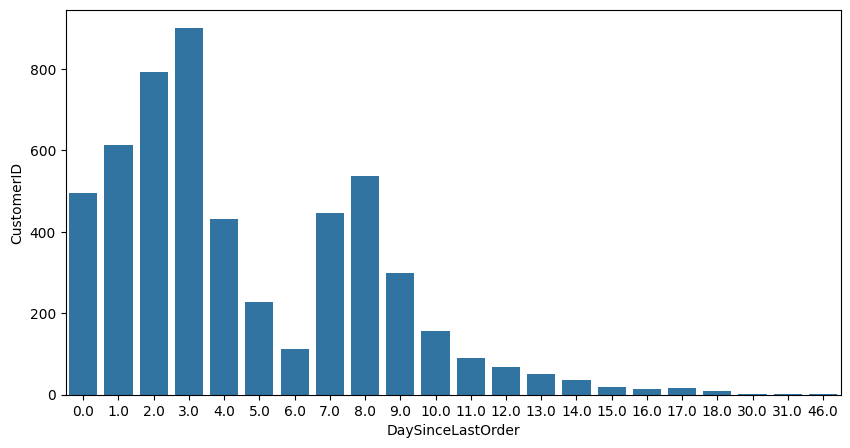

In [7]:
# Check the distribution to decide we will replace with median or 0:
for i in list_null:
    fig, ax = plt.subplots(figsize=(10, 5))
    plot_df = df.groupby(i)[['CustomerID']].count().reset_index()
    sns.barplot(data = plot_df,x=plot_df[i],y= plot_df['CustomerID'],ax=ax)
    plt.show()

Sau khi xem xét về sự phân phối của các cột, ta sẽ thay thế:

*   Tenure: median
*   WarehouseToHome: median
*   HourSpendOnApp: 0
*   OrderAmountHikeFromlastYear: median
*   CounponUsed: 0
*   OrderCount: median
*   DaySinceLastOrder: median

In [8]:
def replace_func(list_columns):
    for i in list_columns:
        if i in ['Tenure','WarehouseToHome','OrderAmountHikeFromlastYear','OrderCount','DaySinceLastOrder']:
            median = df[i].median()
            df[i].fillna(median, inplace=True)
        else:
            df[i].fillna(0, inplace=True)

In [9]:
replace_func(list_null)

<Axes: >

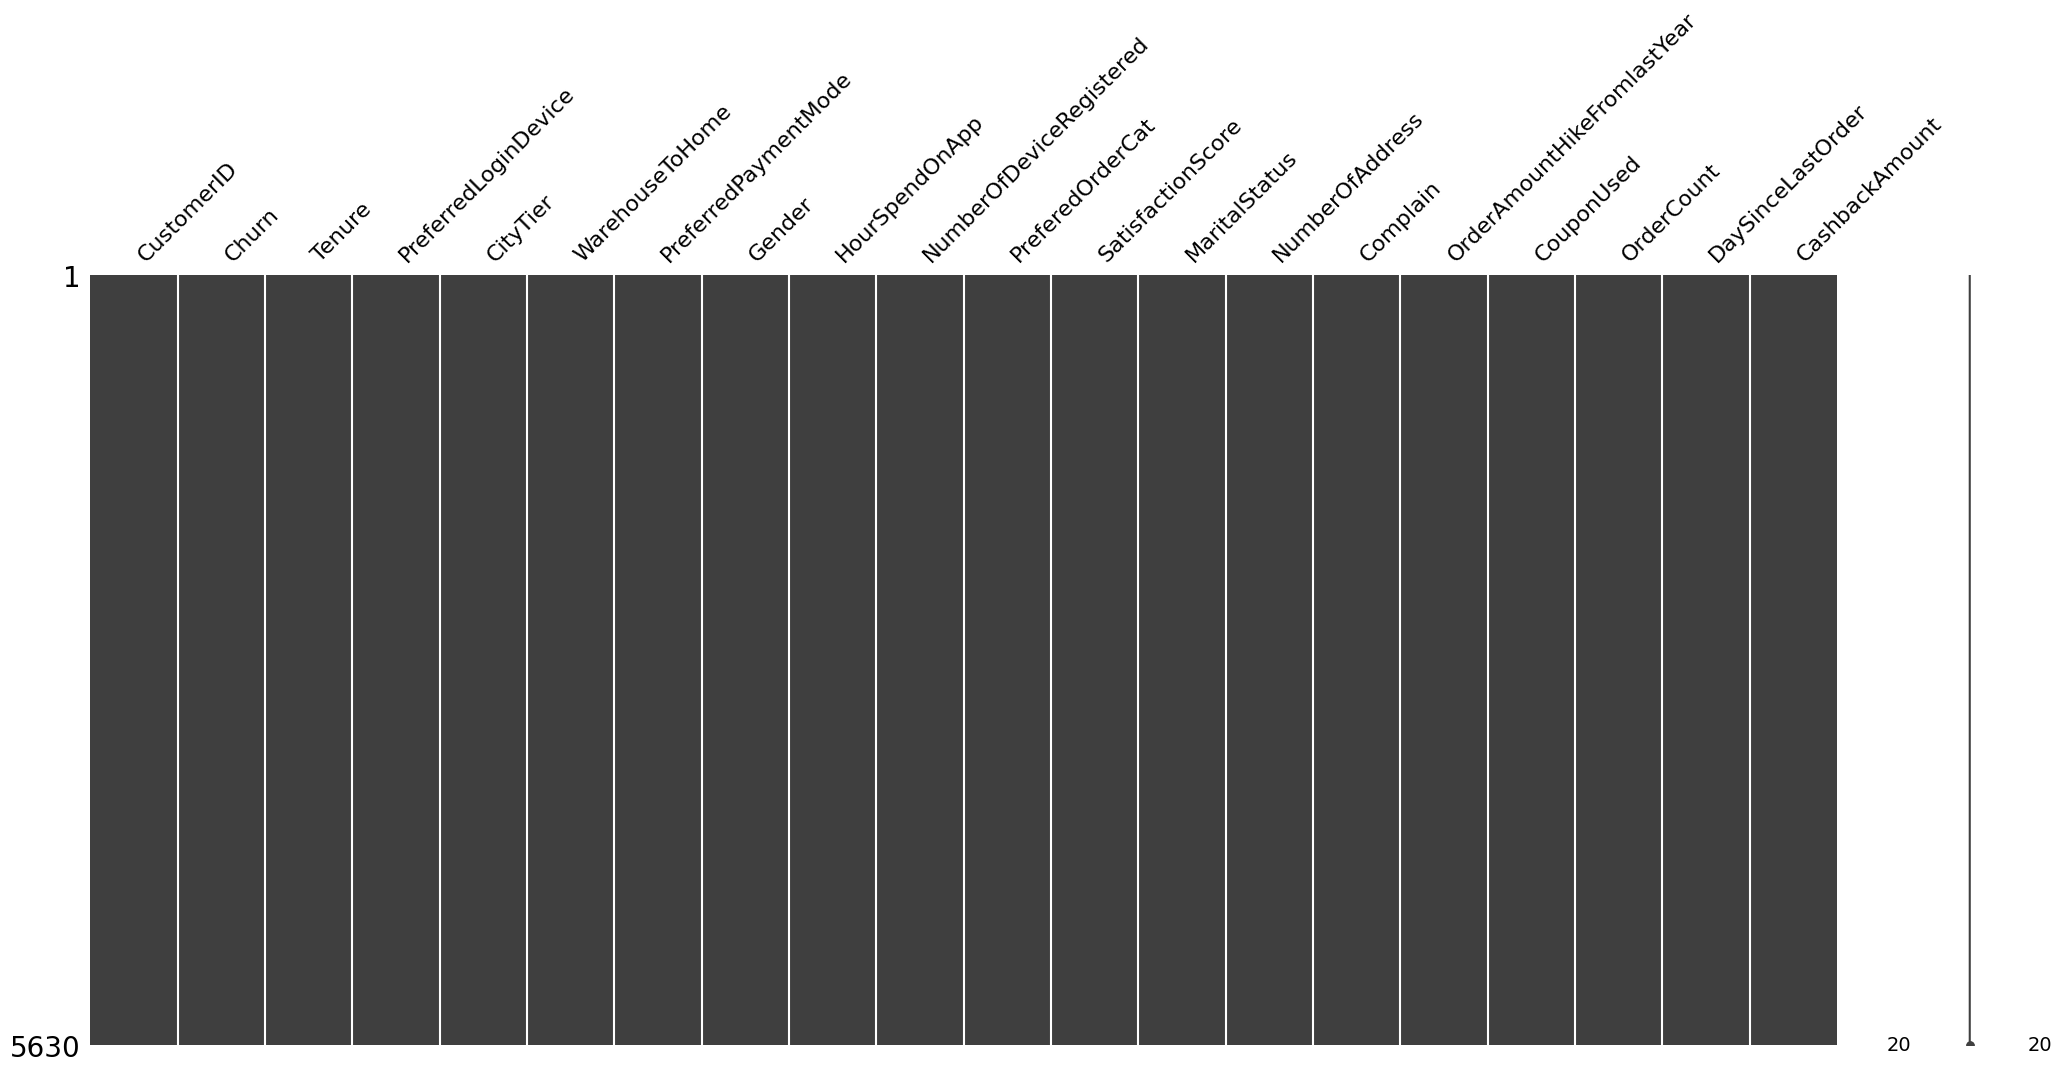

In [10]:
#Check lại missing values sau khi replace
msno.matrix(df)

*1.2.2 Duplicated Values*

In [11]:
df.duplicated().any()

False

→ Data không có duplicated values

1.3 Feature Engineering & EDA

*1.3.1 Check the correlation between all numeric values*

<Axes: >

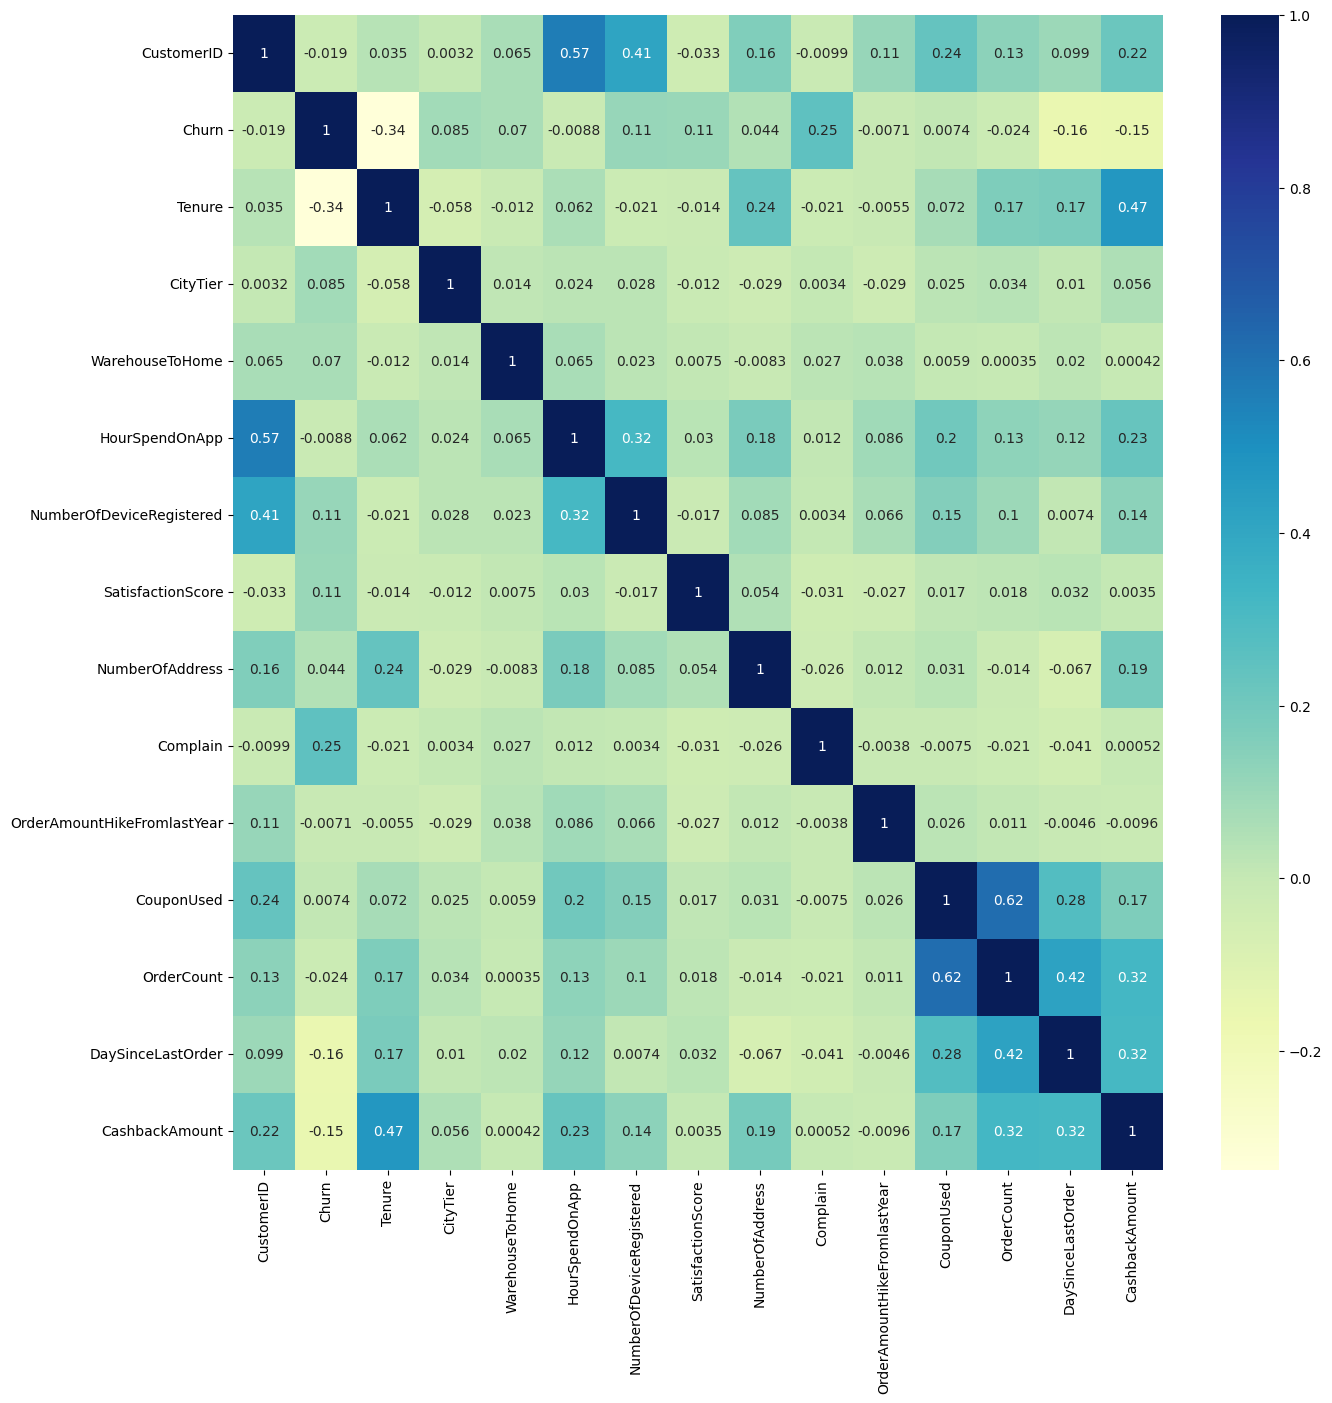

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True, ax=ax)

- Ta thấy, CounponUsed có mối tương quan khá lớn với OrderCount.
- Hiện không có bất kỳ cột nào tương quan với các cột Churn


1.3.2 Visualize to decide the columns

In [13]:
df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

**Tenure: new users are churned more than old users (tenure = 0 or 1)**

In [14]:
# Define a function:
'''
This function to plot the barchart of dataframe
Input:
- the category column need to be groupby
- visualize the data of user churn = 0 or churn=1?

Output:
- the barchart that count "customerid" groupby category column
'''


def cate_visualize(cate_column,churnornot):
    plot_df = df[df['Churn']==churnornot].groupby(cate_column)[['CustomerID']].nunique().reset_index()
    plot_df['%'] = plot_df['CustomerID']/sum(plot_df['CustomerID'])
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(data=plot_df, x=cate_column,y='%', ax=ax)

def numeric_visualize(numeric_column, show_outlier):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df, x='Churn',y=numeric_column,showfliers = show_outlier )



def count_percentage(df, column, target, count):
    '''
    This function to create the table calculate the percentage of fraud/non-fraud transaction on total transaction group by category values

    Input: df: dataframe
    column: the category column need to be groupby
    target: the target column
    count: the column to count the transactions

    Example:
    df = df_train, column = 'job', target = 'is_fraud', count = 'cc_num'

    '''

    # Create 2 dataframes of fraud and non-fraud
    fraud = df[df[target]==1].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)
    not_fraud = df[df[target]==0].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)

    #Merge 2 dataframe into one:
    cate_df = fraud.merge(not_fraud, on = column , how = 'outer')
    cate_df = cate_df.fillna(0)
    cate_df.rename(columns = {count+'_x':'fraud',count+'_y':'not_fraud'}, inplace = True)

    #Caculate the percentage:
    cate_df['%'] = cate_df['fraud']/(cate_df['fraud']+cate_df['not_fraud'])
    cate_df = cate_df.sort_values(by='%', ascending=False)

    return cate_df

In [15]:
df['Tenure'].unique()

array([ 4.,  9.,  0., 13., 11., 19., 20., 14.,  8., 18.,  5.,  2., 30.,
        1., 23.,  3., 29.,  6., 26., 28.,  7., 24., 25., 10., 15., 22.,
       27., 16., 12., 21., 17., 50., 60., 31., 51., 61.])

<Axes: xlabel='Tenure', ylabel='CustomerID'>

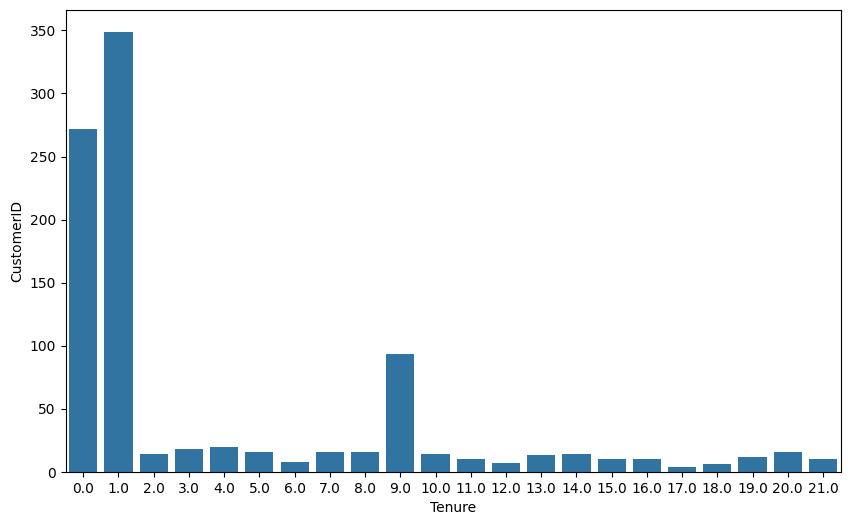

In [16]:
plot_df = df[df['Churn']==1].groupby('Tenure')[['CustomerID']].nunique().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_df, x='Tenure',y='CustomerID', ax=ax)

<Axes: xlabel='Tenure', ylabel='CustomerID'>

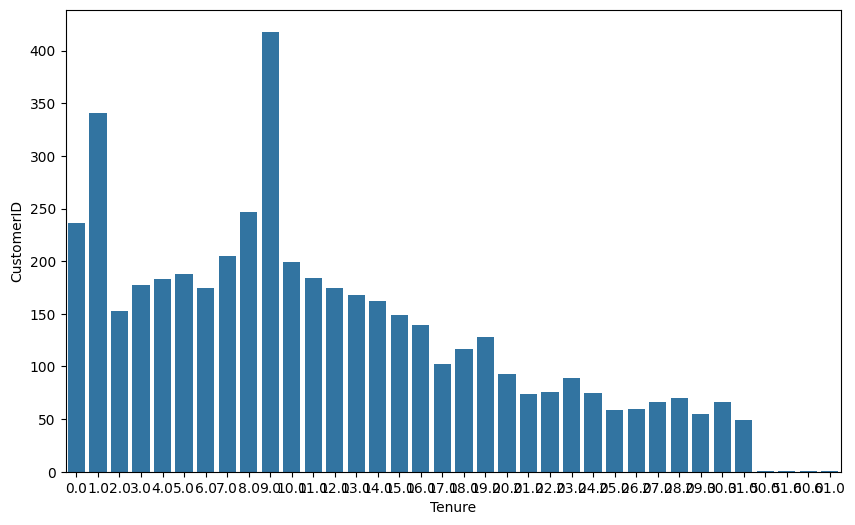

In [17]:
plot_df = df[df['Churn']==0].groupby('Tenure')[['CustomerID']].nunique().reset_index()
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_df, x='Tenure',y='CustomerID', ax=ax)


In [18]:
count_percentage(df, 'Tenure', 'Churn', 'CustomerID')

,Tenure,fraud,not_fraud,%
1,0.0,272.0,236,0.535433
0,1.0,349.0,341,0.505797
2,9.0,93.0,418,0.181996
6,20.0,16.0,93,0.146789
17,21.0,10.0,74,0.119048
3,4.0,20.0,183,0.098522
4,3.0,18.0,177,0.092308
13,19.0,12.0,128,0.085714
9,2.0,14.0,153,0.083832
11,14.0,14.0,162,0.079545


Như 2 plots, chúng ta thấy rằng khách hàng rời bỏ thường là những khách hàng mới



**Prefer Login Devices**

In [19]:
df['PreferredLoginDevice'].unique()

array(['Mobile Phone', 'Phone', 'Computer'], dtype=object)

In [20]:
#Replace Mobile Phone to Phone
df['PreferredLoginDevice'].replace({'Mobile Phone':'Phone'}, inplace=True)

In [21]:
df['PreferredLoginDevice'].unique()

array(['Phone', 'Computer'], dtype=object)

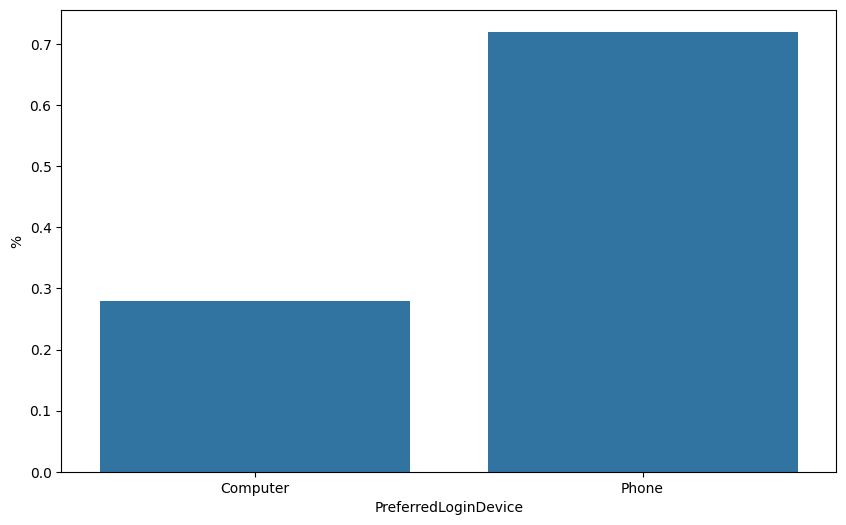

In [22]:
cate_visualize('PreferredLoginDevice',0)

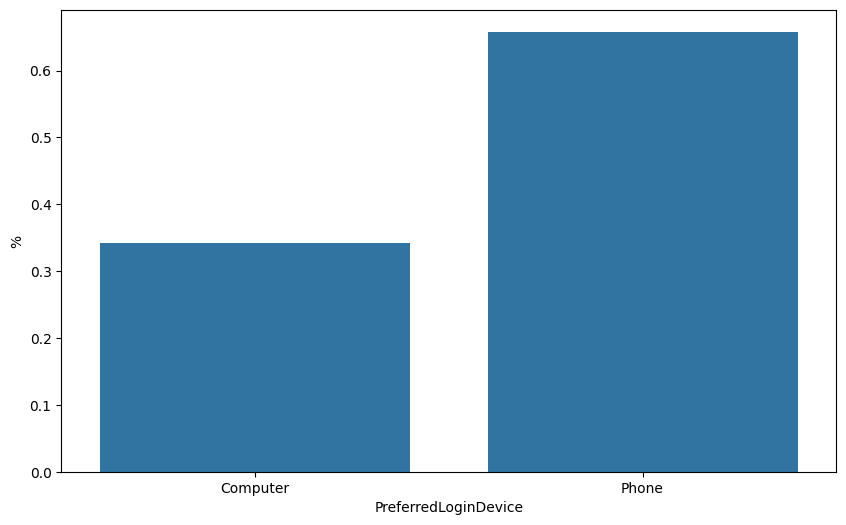

In [23]:
cate_visualize('PreferredLoginDevice',1)

In [24]:
count_percentage(df, 'PreferredLoginDevice', 'Churn', 'CustomerID')

,PreferredLoginDevice,fraud,not_fraud,%
1,Computer,324,1310,0.198286
0,Phone,624,3372,0.156156


Đối với người dùng rời bỏ hoặc không rời bỏ, họ sử dụng điện thoại nhiều hơn máy tính.

**City Tier**

In [25]:
df['CityTier'].unique()

array([3, 1, 2])

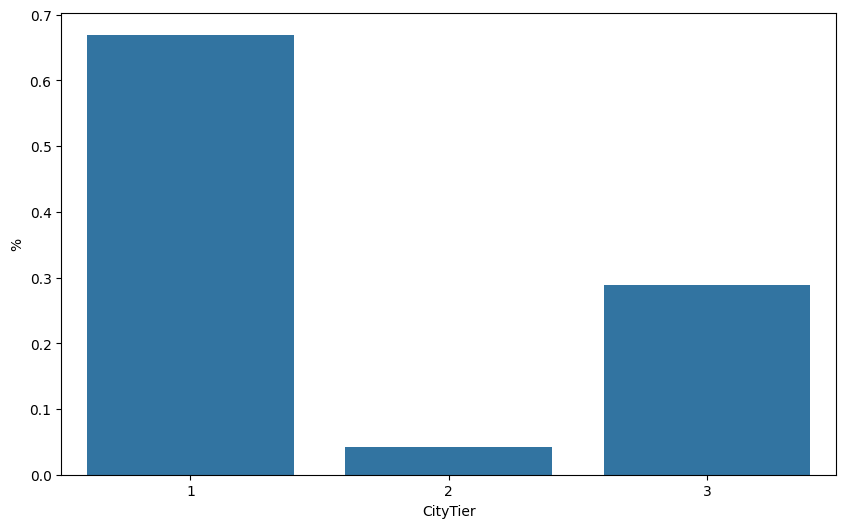

In [26]:
cate_visualize('CityTier',0)

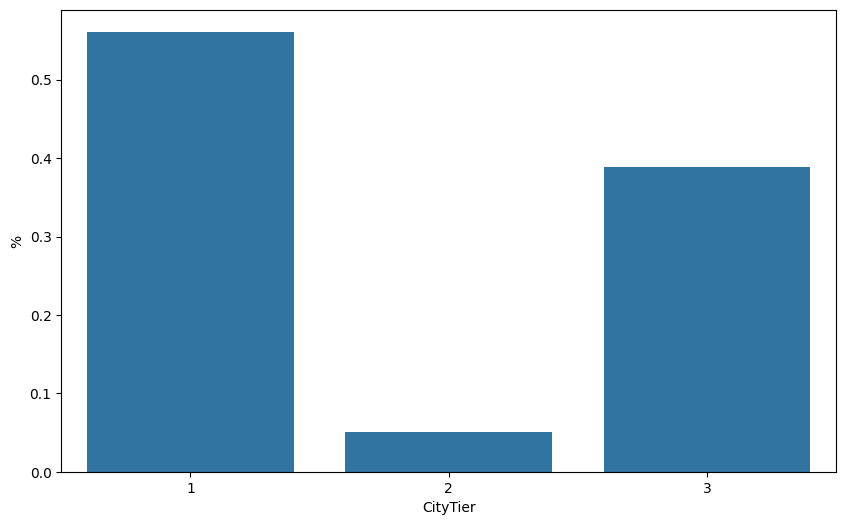

In [27]:
cate_visualize('CityTier',1)

In [28]:
count_percentage(df, 'CityTier', 'Churn', 'CustomerID')

,CityTier,fraud,not_fraud,%
1,3,368,1354,0.213705
2,2,48,194,0.198347
0,1,532,3134,0.145117


Đối với cả người dùng rời bỏ hoặc không rời bỏ, phần lớn họ sống ở CityTier=1 và CityTier=3 và ở CityTier = 3, người dùng có xu hướng rời bỏ nhiều hơn.

**Warehouse To Home**


In [29]:
df['WarehouseToHome'].dtype

dtype('float64')

<Axes: xlabel='Churn', ylabel='WarehouseToHome'>

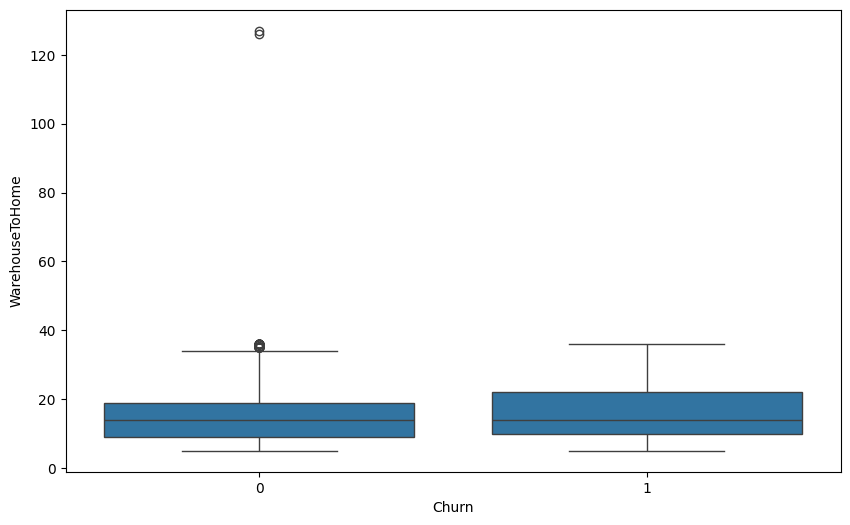

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df, x='Churn',y='WarehouseToHome',ax=ax)

<Axes: xlabel='Churn', ylabel='WarehouseToHome'>

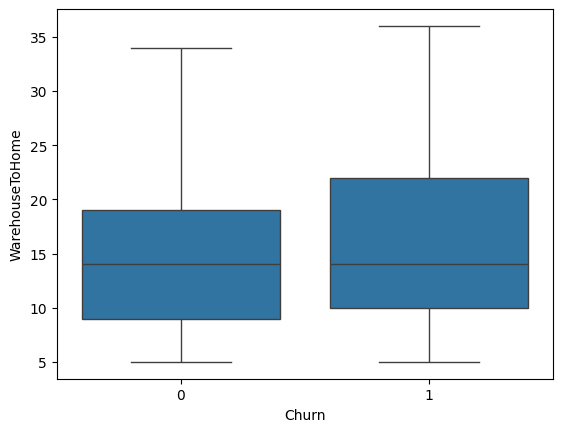

In [31]:
sns.boxplot(data=df, x='Churn',y='WarehouseToHome', showfliers = False)

Chúng ta thấy rằng phạm vi không khác biệt đáng kể giữa người dùng rời bỏ và không rời bỏ.

**Preferred Payment Mode**

In [32]:
df['PreferredPaymentMode'].unique()

array(['Debit Card', 'UPI', 'CC', 'Cash on Delivery', 'E wallet', 'COD',
       'Credit Card'], dtype=object)

In [33]:
df['PreferredPaymentMode'].replace({'CC':'Credit Card','COD':'Cash on Delivery'}, inplace=True)

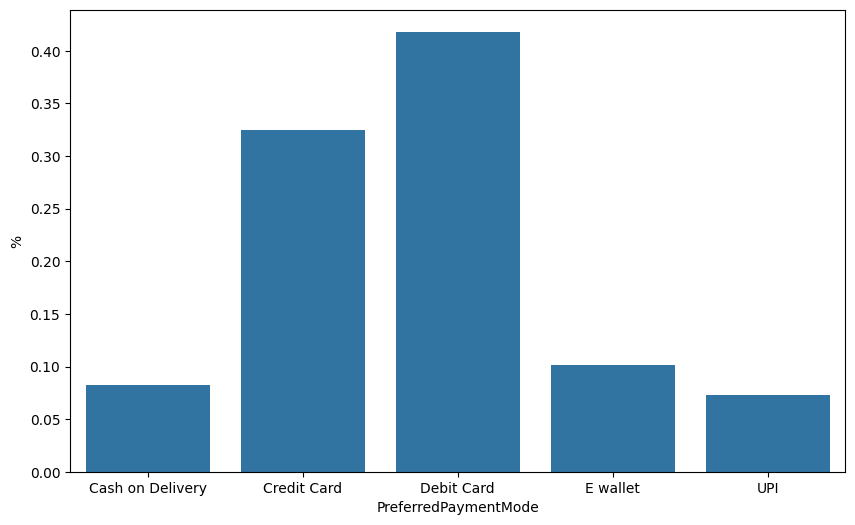

In [34]:
cate_visualize('PreferredPaymentMode',0)

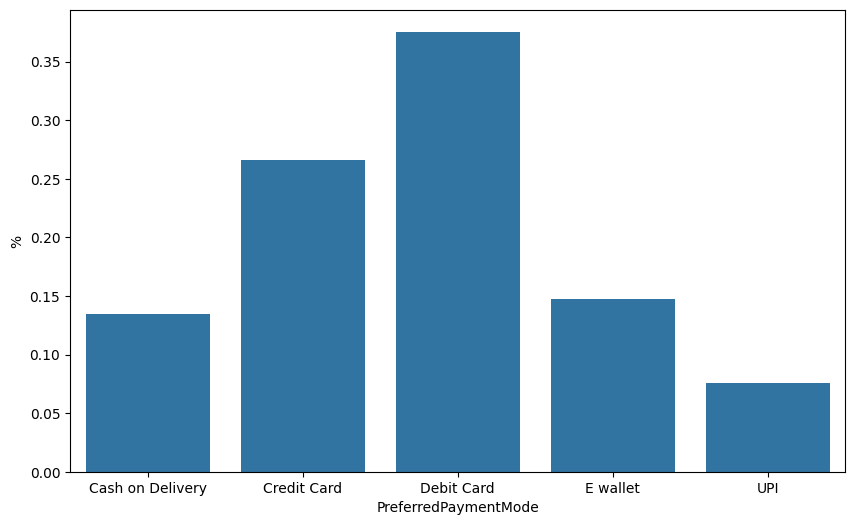

In [35]:
cate_visualize('PreferredPaymentMode',1)

In [36]:
count_percentage(df, 'PreferredPaymentMode', 'Churn', 'CustomerID')

,PreferredPaymentMode,fraud,not_fraud,%
3,Cash on Delivery,128,386,0.249027
2,E wallet,140,474,0.228013
4,UPI,72,342,0.173913
0,Debit Card,356,1958,0.153846
1,Credit Card,252,1522,0.142052


Không có sự khác biệt đáng kể về phương thức thanh toán giữa người dùng đã rời bỏ và không bị rời bỏ

**Gender**

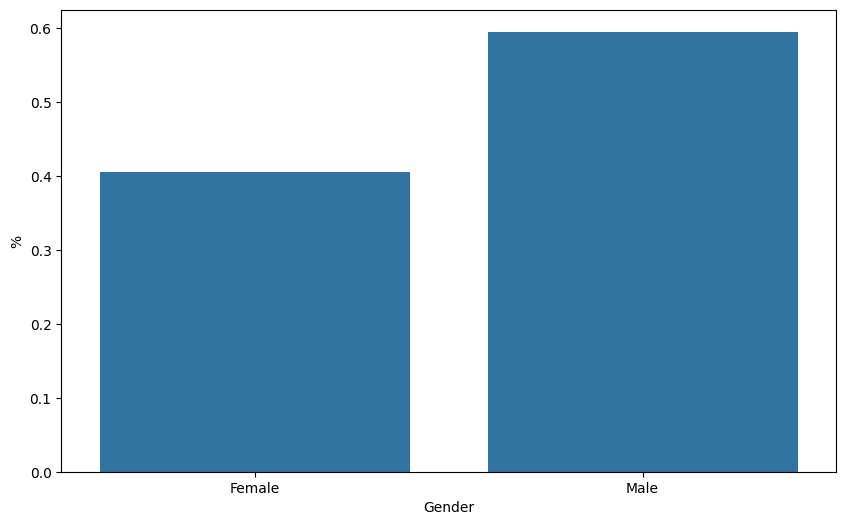

In [37]:
cate_visualize('Gender',0)

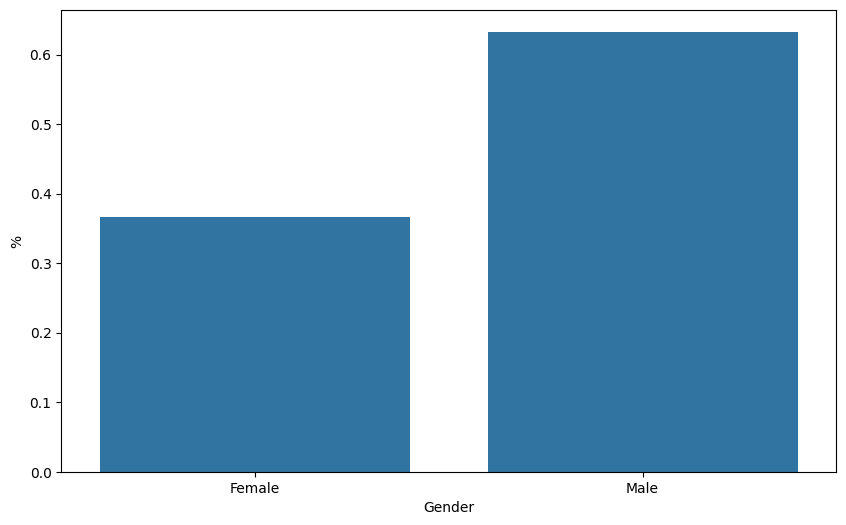

In [38]:
cate_visualize('Gender',1)

In [39]:
count_percentage(df, 'Gender', 'Churn', 'CustomerID')

,Gender,fraud,not_fraud,%
0,Male,600,2784,0.177305
1,Female,348,1898,0.154942


Không có sự khác biệt đáng kể về giới tính giữa người dùng rời bỏ và không rời bỏ

**Hour Spend on app**

In [40]:
df['HourSpendOnApp'].dtype

dtype('float64')

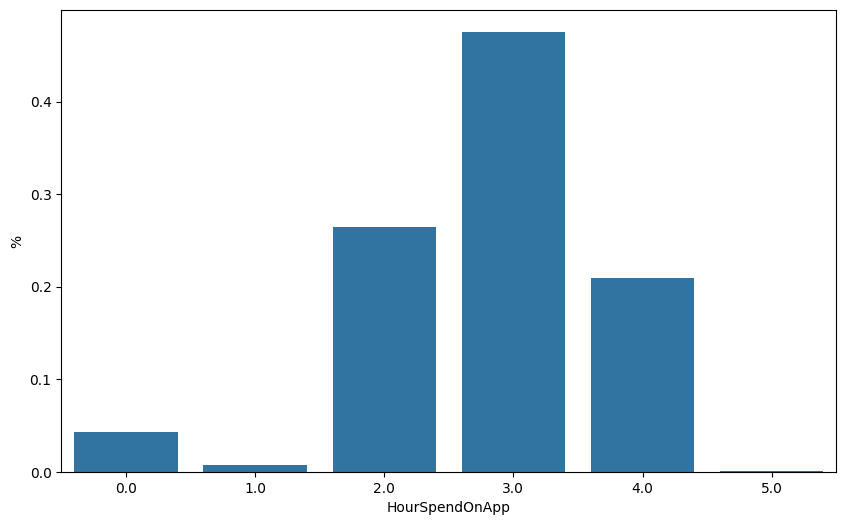

In [41]:
cate_visualize('HourSpendOnApp',0)

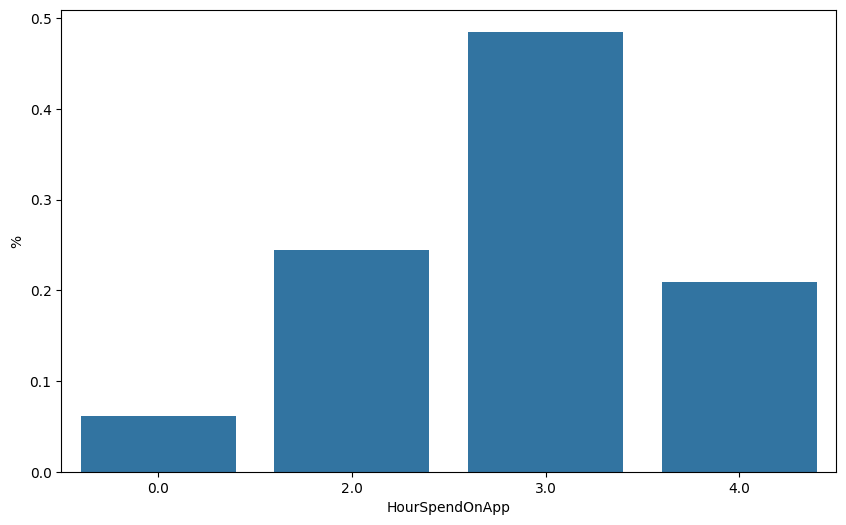

In [42]:
cate_visualize('HourSpendOnApp',1)

In [43]:
count_percentage(df, 'HourSpendOnApp', 'Churn', 'CustomerID')

,HourSpendOnApp,fraud,not_fraud,%
3,0.0,58.0,200,0.224806
0,3.0,460.0,2227,0.171195
2,4.0,198.0,978,0.168367
1,2.0,232.0,1239,0.157716
4,1.0,0.0,35,0.000000
5,5.0,0.0,3,0.000000


Chúng tôi thấy rằng trong hour =1 và hour =5, không có người dùng nào có fraud cả. Tuy nhiên, mẫu trong phạm vi hour này quá nhỏ nên không có nhiều ý nghĩa để chúng ta kết luận.

→ Có thể kết luận rằng không có sự khác biệt đáng kể giữa việc rời bỏ và không rời bỏ về số giờ mà họ dành cho app

**Number Of Devices Registering**: *The more devices users registered, the more users tend to fraud*


In [44]:
df['NumberOfDeviceRegistered'].unique()


array([3, 4, 5, 2, 1, 6])

In [45]:
df['NumberOfDeviceRegistered'].dtype


dtype('int64')

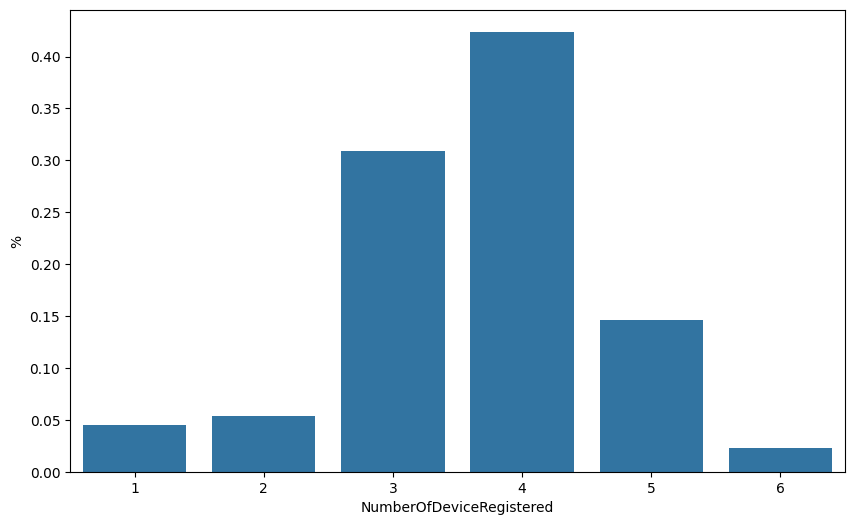

In [46]:
cate_visualize('NumberOfDeviceRegistered',0)


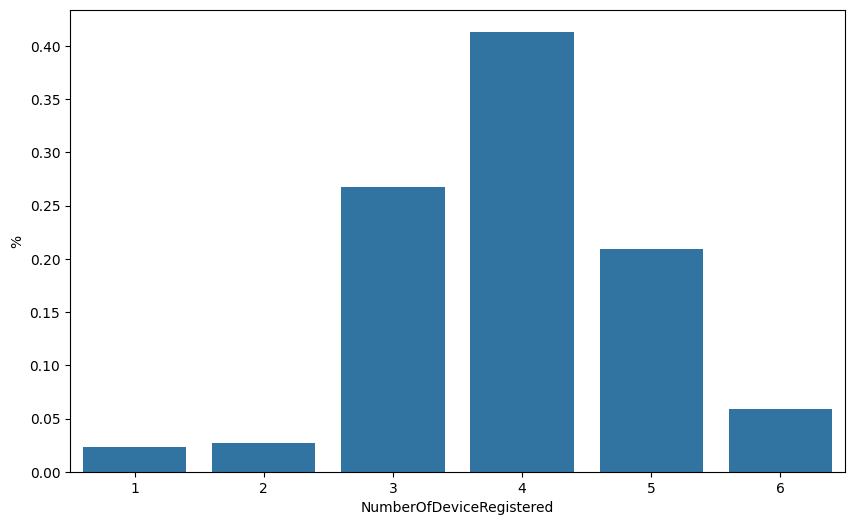

In [47]:
cate_visualize('NumberOfDeviceRegistered',1)


In [48]:
count_percentage(df, 'NumberOfDeviceRegistered', 'Churn', 'CustomerID')

,NumberOfDeviceRegistered,fraud,not_fraud,%
3,6,56,106,0.345679
2,5,198,683,0.224745
0,4,392,1985,0.164914
1,3,254,1445,0.149500
4,2,26,250,0.094203
5,1,22,213,0.093617


Người dùng đăng ký càng nhiều thiết bị, càng có xu hướng lừa đảo.

**Prefer orders category:** *Churn users refer to buy Mobile Phone than others*

In [49]:
df['PreferedOrderCat'].unique()

array(['Laptop & Accessory', 'Mobile', 'Mobile Phone', 'Others',
       'Fashion', 'Grocery'], dtype=object)

In [50]:
df['PreferedOrderCat'].replace({'Mobile':'Mobile Phone'},inplace=True)

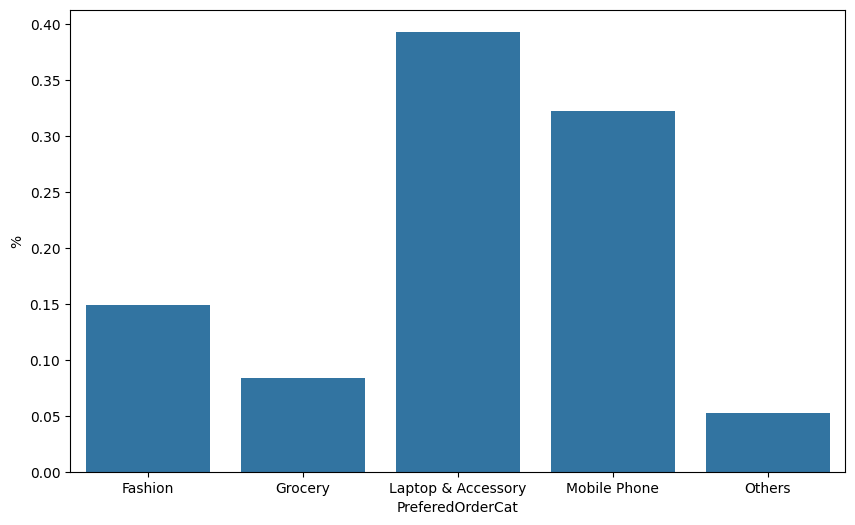

In [51]:
cate_visualize('PreferedOrderCat',0)

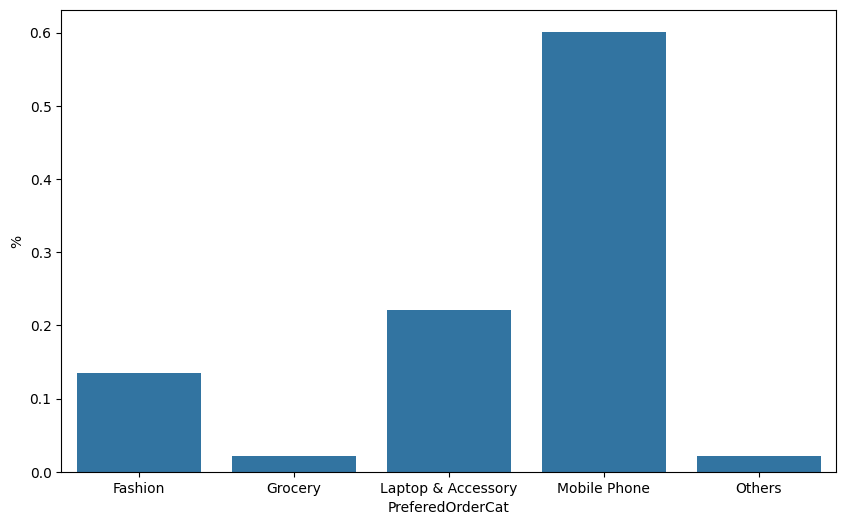

In [52]:
cate_visualize('PreferedOrderCat',1)

In [53]:
count_percentage(df, 'PreferedOrderCat', 'Churn', 'CustomerID')

,PreferedOrderCat,fraud,not_fraud,%
0,Mobile Phone,570,1510,0.274038
2,Fashion,128,698,0.154964
1,Laptop & Accessory,210,1840,0.102439
4,Others,20,244,0.075758
3,Grocery,20,390,0.048780


Đối với người dùng rời bỏ:

- Họ mua Mobile Phone	nhiều hơn những người khác.
- Họ mua Grocery & Laptop & Accessory ít hơn những người không rời bỏ

**Satisfaction Score**

In [54]:
df['SatisfactionScore'].unique()

array([2, 3, 5, 4, 1])

In [55]:
df['SatisfactionScore'].dtype

dtype('int64')

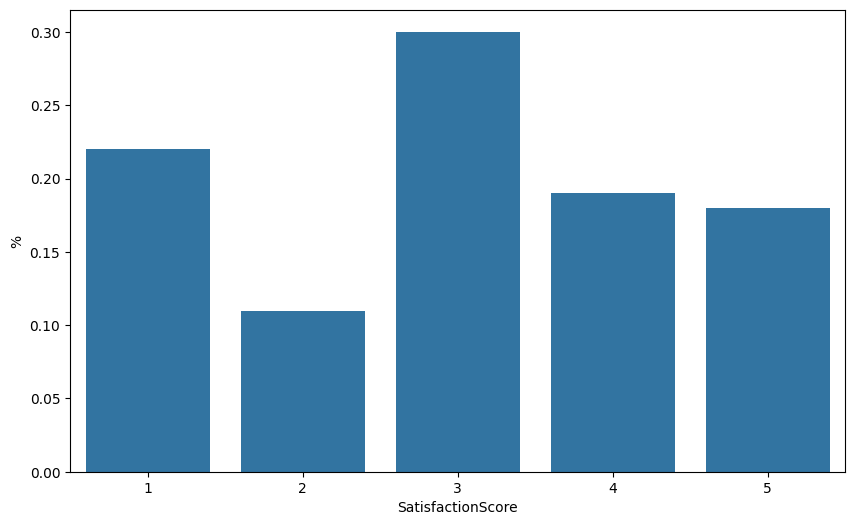

In [56]:
cate_visualize('SatisfactionScore',0)

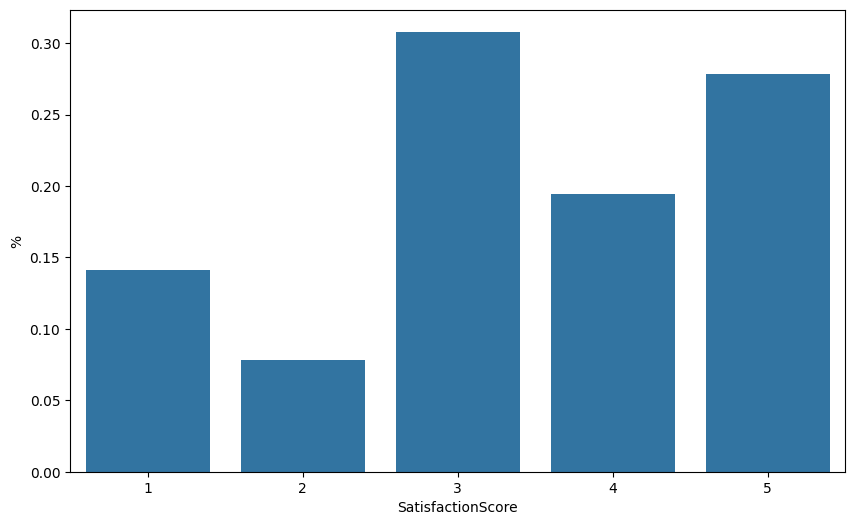

In [57]:
cate_visualize('SatisfactionScore',1)

In [58]:
count_percentage(df, 'SatisfactionScore', 'Churn', 'CustomerID')

,SatisfactionScore,fraud,not_fraud,%
1,5,264,844,0.238267
0,3,292,1406,0.171967
2,4,184,890,0.171322
4,2,74,512,0.126280
3,1,134,1030,0.115120


Người dùng rời bỏ có phần trăm thấp hơn tại score = 1 so với người dùng không rời bỏ và có cao hơn tại mức score = 5

→ Mặc dù có sự khác biệt đáng kể giữa việc rời bỏ và không rời bỏ ở điểm 1 và 5, nhưng không có ý nghĩa gì về khía cạnh logic. Nếu chúng ta thêm tính năng này vào mô hình, kết quả không logic có thể xảy ra.

**Maritual Status:** *Churned users have status Single more than notchurn users*

In [59]:
df['MaritalStatus'].unique()

array(['Single', 'Divorced', 'Married'], dtype=object)

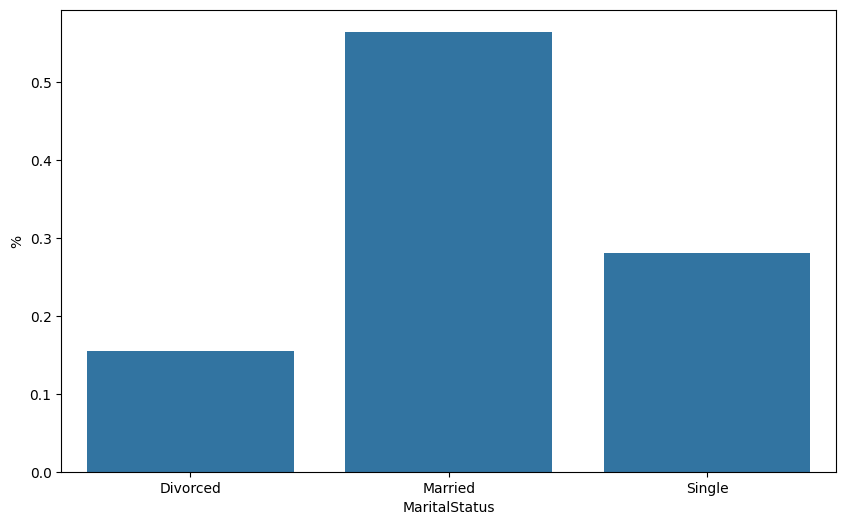

In [60]:
cate_visualize('MaritalStatus',0)

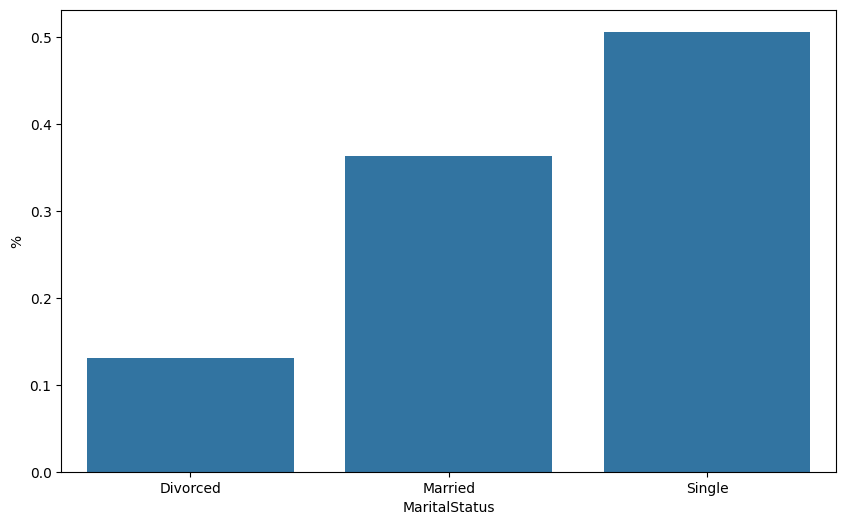

In [61]:
cate_visualize('MaritalStatus',1)

In [62]:
count_percentage(df, 'MaritalStatus', 'Churn', 'CustomerID')

,MaritalStatus,fraud,not_fraud,%
0,Single,480,1316,0.267261
2,Divorced,124,724,0.146226
1,Married,344,2642,0.115204


Người dùng rời bỏ có tình trạng **độc thân** nhiều hơn là người dùng không rời bỏ. Và người dùng không rời bỏ có tình trạng **kết hôn** nhiều hơn là rời bỏ.




**Number of Address**

In [63]:
df['NumberOfAddress'].dtype

dtype('int64')

In [64]:
df['NumberOfAddress'].unique()

array([ 9,  7,  6,  8,  3,  2,  4, 10,  1,  5, 19, 21, 11, 20, 22])

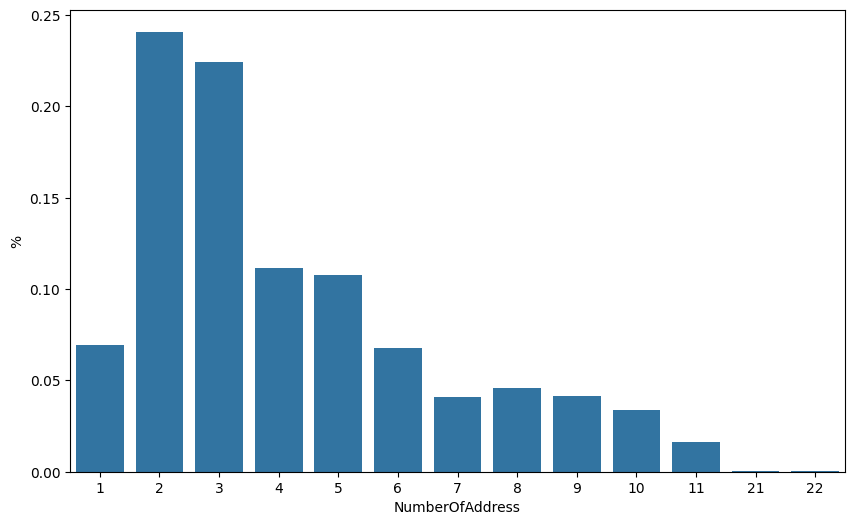

In [65]:
cate_visualize('NumberOfAddress',0)

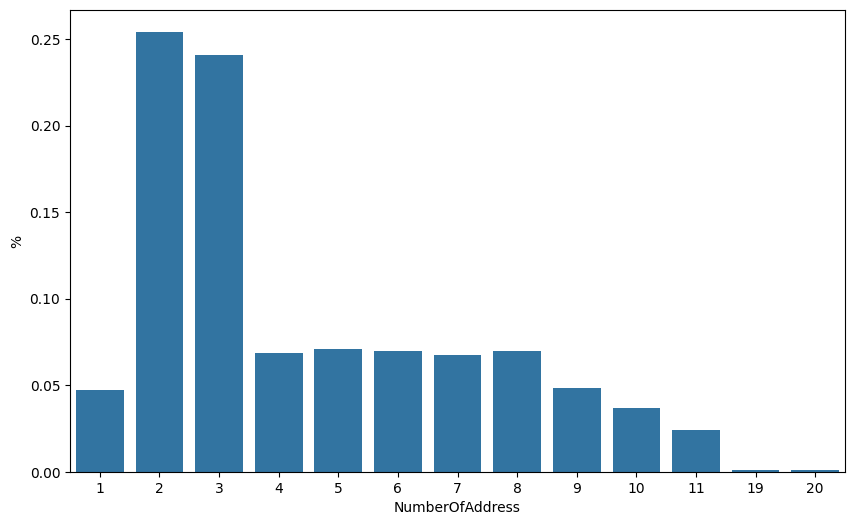

In [66]:
cate_visualize('NumberOfAddress',1)

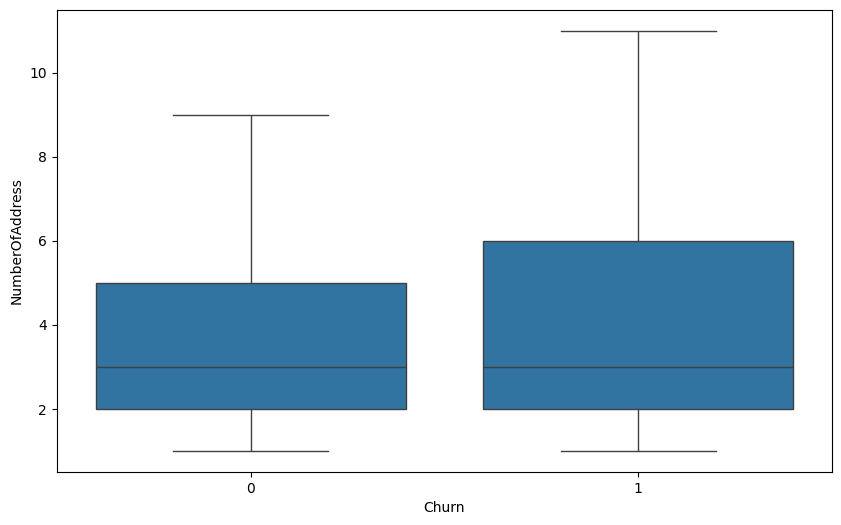

In [67]:
numeric_visualize('NumberOfAddress', False)

In [68]:
count_percentage(df, 'NumberOfAddress', 'Churn', 'CustomerID')

,NumberOfAddress,fraud,not_fraud,%
11,19,1.0,0.0,1.000000
12,20,1.0,0.0,1.000000
6,7,64.0,192.0,0.250000
4,8,66.0,214.0,0.235714
10,11,23.0,75.0,0.234694
7,9,46.0,193.0,0.192469
9,10,35.0,159.0,0.180412
1,3,228.0,1050.0,0.178404
0,2,241.0,1128.0,0.176041
3,6,66.0,316.0,0.172775



Không có sự khác biệt đáng kể giữa người dùng rời bỏ và không rời bỏ về số lượng địa chỉ

**Complain:** *The number of users complain on churn is higher than not churn*


In [69]:
df['Complain'].dtype

dtype('int64')

In [70]:
df['Complain'].unique()

array([1, 0])

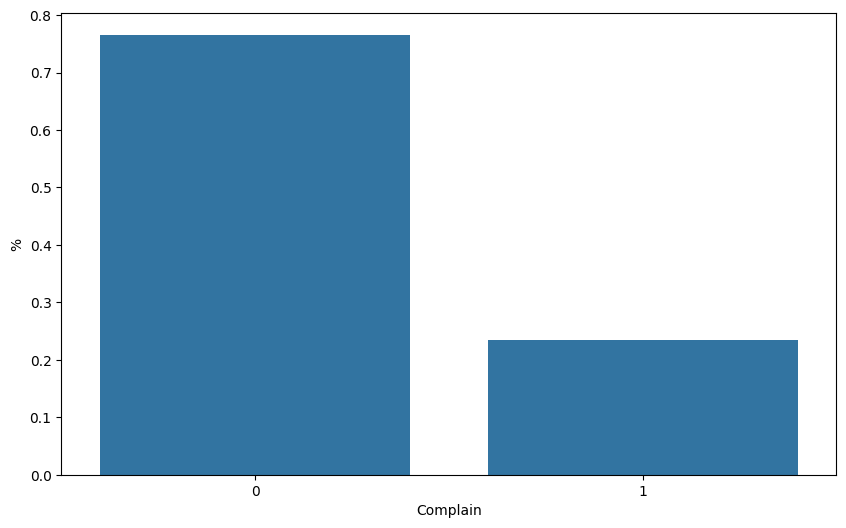

In [71]:
cate_visualize('Complain',0)

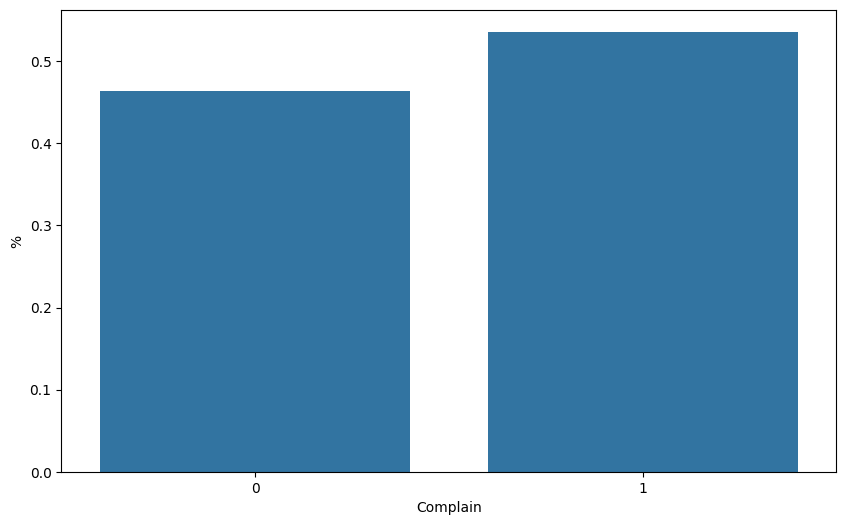

In [72]:
cate_visualize('Complain',1)

In [73]:
count_percentage(df, 'Complain', 'Churn', 'CustomerID')

,Complain,fraud,not_fraud,%
0,1,508,1096,0.316708
1,0,440,3586,0.109290


Số lượng người dùng phàn nàn rời bỏ nhiều hơn là không rời bỏ

**Order Amount Hike From last Year**

In [74]:
df['OrderAmountHikeFromlastYear'].dtype


dtype('float64')

In [75]:
df['OrderAmountHikeFromlastYear'].unique()

array([11., 15., 14., 23., 22., 16., 12., 13., 17., 18., 24., 19., 20.,
       21., 25., 26.])

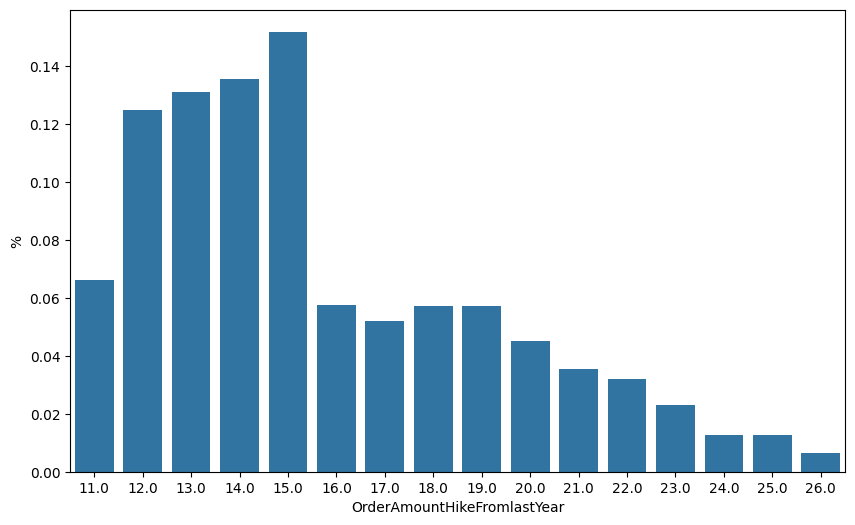

In [76]:
cate_visualize('OrderAmountHikeFromlastYear',0)

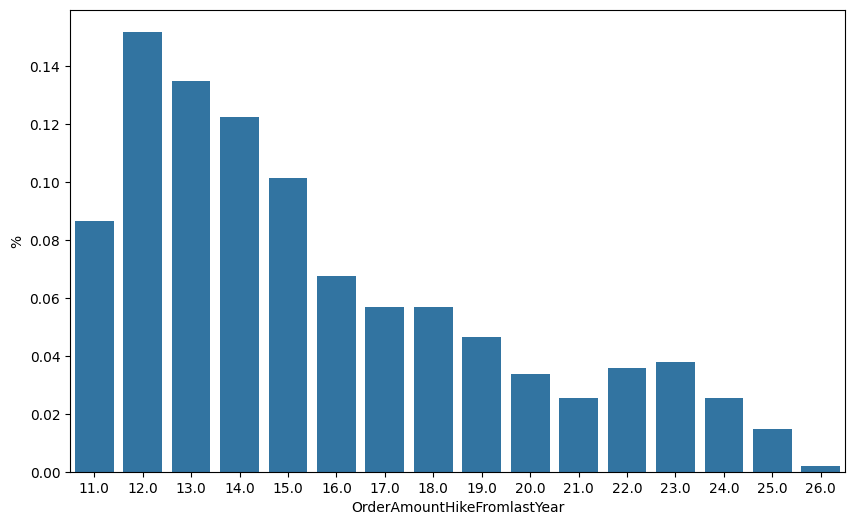

In [77]:
cate_visualize('OrderAmountHikeFromlastYear',1)

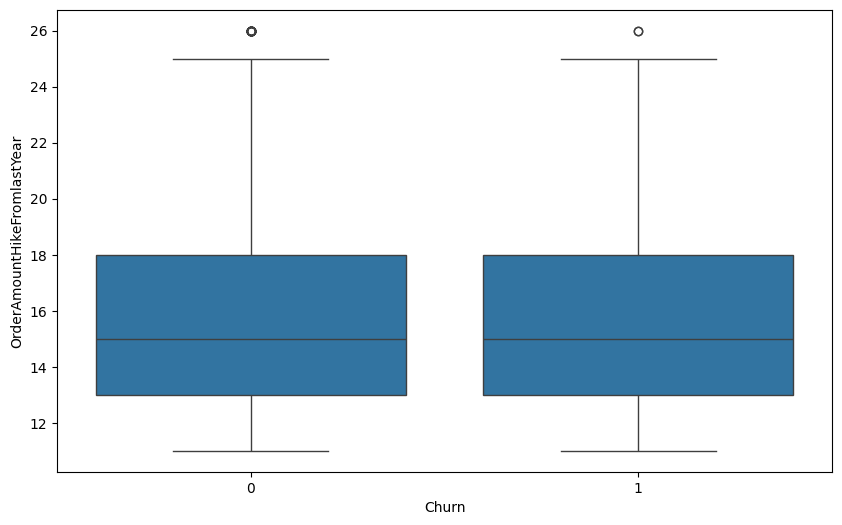

In [78]:
numeric_visualize('OrderAmountHikeFromlastYear', True)

In [79]:
count_percentage(df, 'OrderAmountHikeFromlastYear', 'Churn', 'CustomerID')

,OrderAmountHikeFromlastYear,fraud,not_fraud,%
13,24.0,24,60,0.285714
9,23.0,36,108,0.250000
4,11.0,82,309,0.209719
0,12.0,144,584,0.197802
5,16.0,64,269,0.192192
14,25.0,14,59,0.191781
10,22.0,34,150,0.184783
6,17.0,54,243,0.181818
1,13.0,128,613,0.172740
7,18.0,54,267,0.168224


Không có sự khác biệt đáng kể giữa người dùng rời bỏ và không rời bỏ trong số lượng đơn đặt hàng tăng so với năm ngoái.

**Coupon Used**

In [80]:
df['CouponUsed'].unique()

array([ 1.,  0.,  4.,  2.,  9.,  6., 11.,  7., 12., 10.,  5.,  3., 13.,
       15.,  8., 14., 16.])

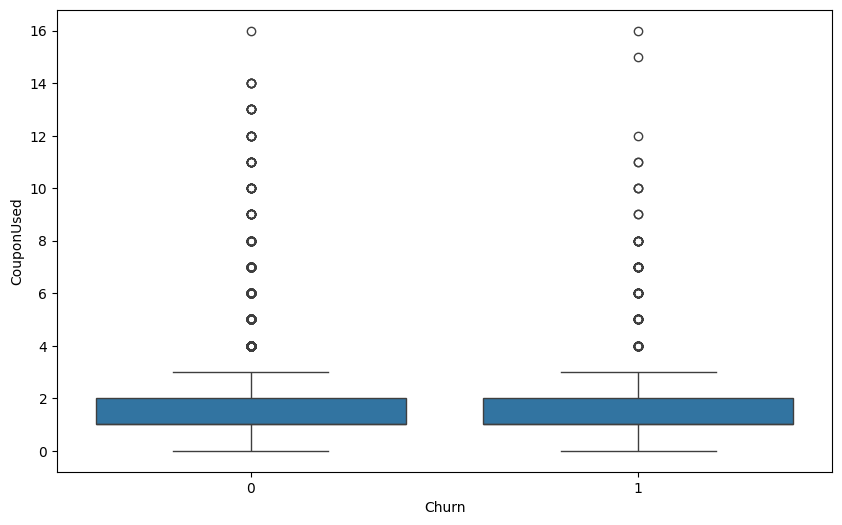

In [81]:
numeric_visualize('CouponUsed',True)

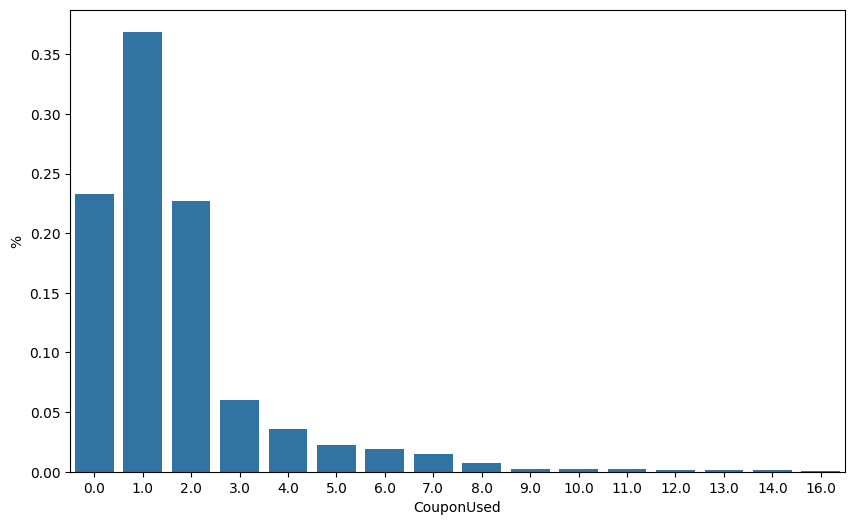

In [82]:
cate_visualize('CouponUsed',0)

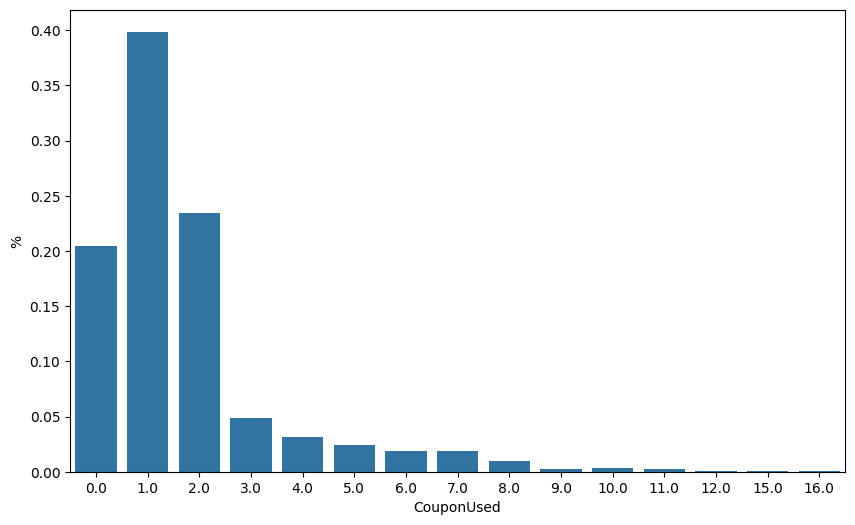

In [83]:
cate_visualize('CouponUsed',1)

In [84]:
count_percentage(df, 'CouponUsed', 'Churn', 'CustomerID')

,CouponUsed,fraud,not_fraud,%
13,15.0,1.0,0.0,1.000000
14,16.0,1.0,1.0,0.500000
8,8.0,9.0,33.0,0.214286
9,10.0,3.0,11.0,0.214286
7,7.0,18.0,71.0,0.202247
0,1.0,378.0,1727.0,0.179572
5,5.0,23.0,106.0,0.178295
1,2.0,222.0,1061.0,0.173032
6,6.0,18.0,90.0,0.166667
11,11.0,2.0,10.0,0.166667


Không có sự khác biệt đáng kể giữa người dùng rời bỏ và người dùng không rời bỏ về sử dụng phiếu giảm giá.

**Order Count**

In [85]:
df['OrderCount'].dtype

dtype('float64')

In [86]:
df['OrderCount'].unique()

array([ 1.,  6.,  2., 15.,  4.,  7.,  3.,  9., 11.,  5., 12., 10.,  8.,
       13., 14., 16.])

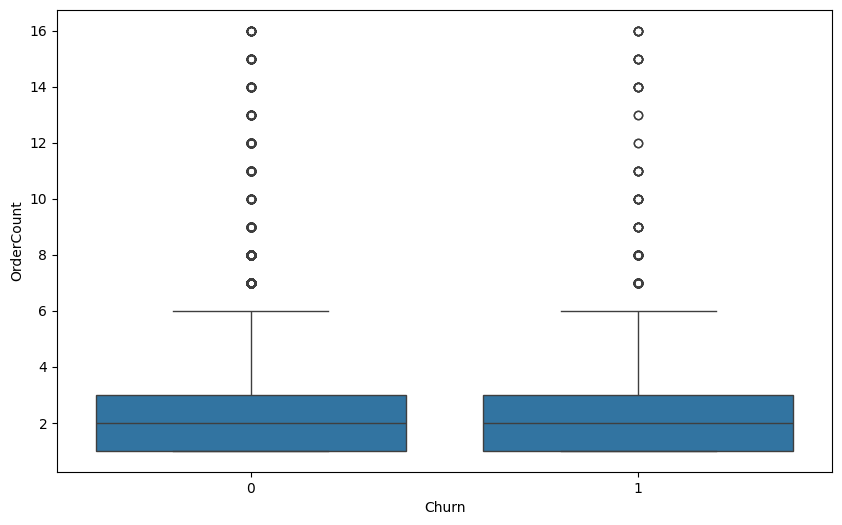

In [87]:
numeric_visualize('OrderCount',True)

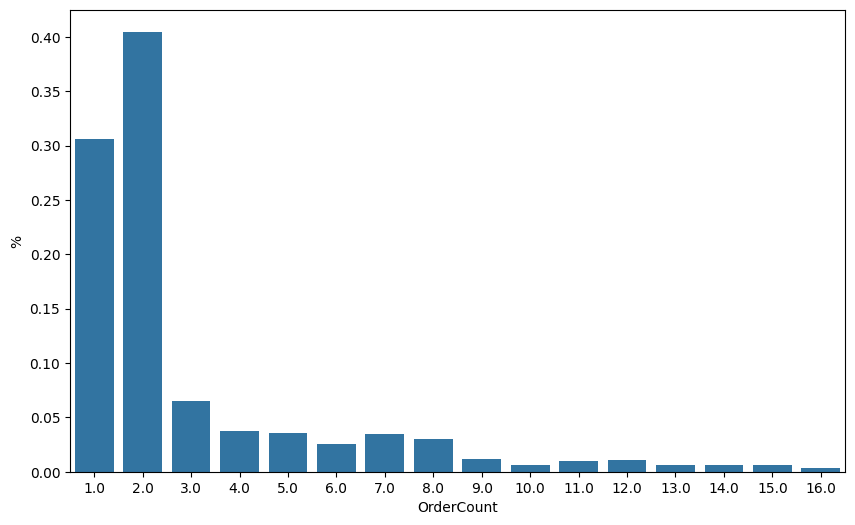

In [88]:
cate_visualize('OrderCount',0)

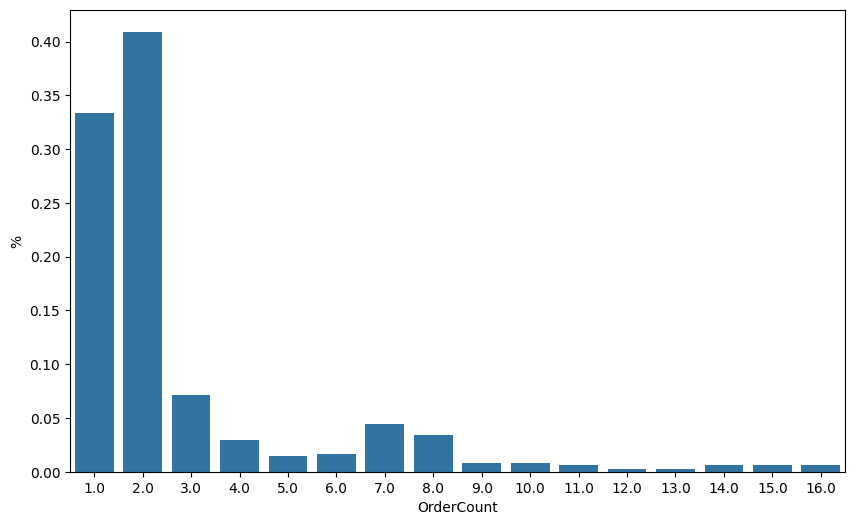

In [89]:
cate_visualize('OrderCount',1)

In [90]:
count_percentage(df, 'OrderCount', 'Churn', 'CustomerID')

,OrderCount,fraud,not_fraud,%
13,16.0,6,17,0.260870
9,10.0,8,28,0.222222
3,7.0,42,164,0.203883
4,8.0,32,140,0.186047
2,3.0,68,303,0.183288
12,15.0,6,27,0.181818
1,1.0,316,1435,0.180468
0,2.0,388,1895,0.169952
11,14.0,6,30,0.166667
5,4.0,28,176,0.137255


Không có sự khác biệt đáng kể giữa người dùng rời bỏ và người dùng không rời bỏ về số lượng đơn đặt hàng.

**Day Since Last Order**

In [91]:
df['DaySinceLastOrder'].dtype

dtype('float64')

In [92]:
df['DaySinceLastOrder'].unique()

array([ 5.,  0.,  3.,  7.,  2.,  1.,  8.,  6.,  4., 15.,  9., 11., 10.,
       13., 12., 17., 16., 14., 30., 46., 18., 31.])

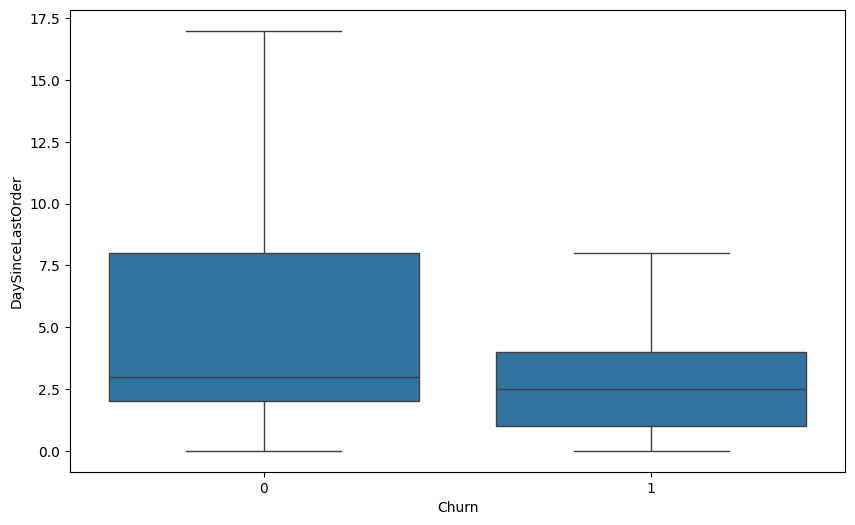

In [93]:
numeric_visualize('DaySinceLastOrder',False)

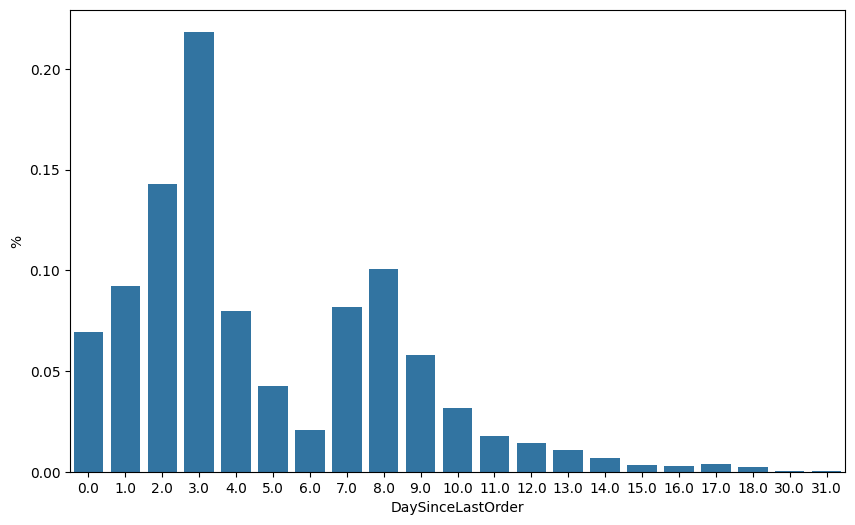

In [94]:
cate_visualize('DaySinceLastOrder',0)

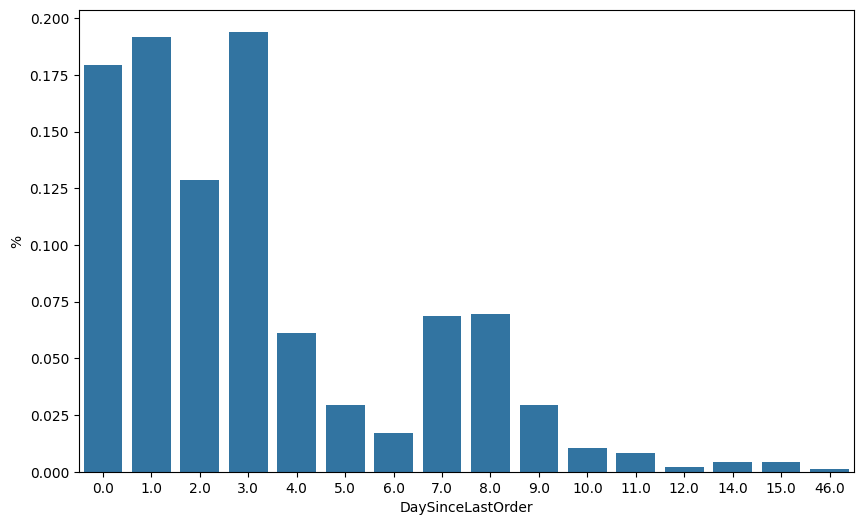

In [95]:
cate_visualize('DaySinceLastOrder',1)

In [96]:
count_percentage(df, 'DaySinceLastOrder', 'Churn', 'CustomerID')

,DaySinceLastOrder,fraud,not_fraud,%
15,46.0,1.0,0.0,1.000000
2,0.0,170.0,326.0,0.342742
1,1.0,182.0,432.0,0.296417
13,15.0,4.0,15.0,0.210526
3,2.0,122.0,670.0,0.154040
0,3.0,184.0,1023.0,0.152444
5,7.0,65.0,382.0,0.145414
9,6.0,16.0,97.0,0.141593
6,4.0,58.0,373.0,0.134571
7,5.0,28.0,200.0,0.122807


Không có sự khác biệt đáng kể giữa số ngày người dùng rời bỏ và người dùng không rời bỏ tính từ đơn đặt hàng cuối cùng.

**Cashback Amount:** *Churn users recevied cashback amount less than not churn users.*

In [97]:
df['CashbackAmount'].dtype

dtype('float64')

In [98]:
df['CashbackAmount'].nunique()

2586

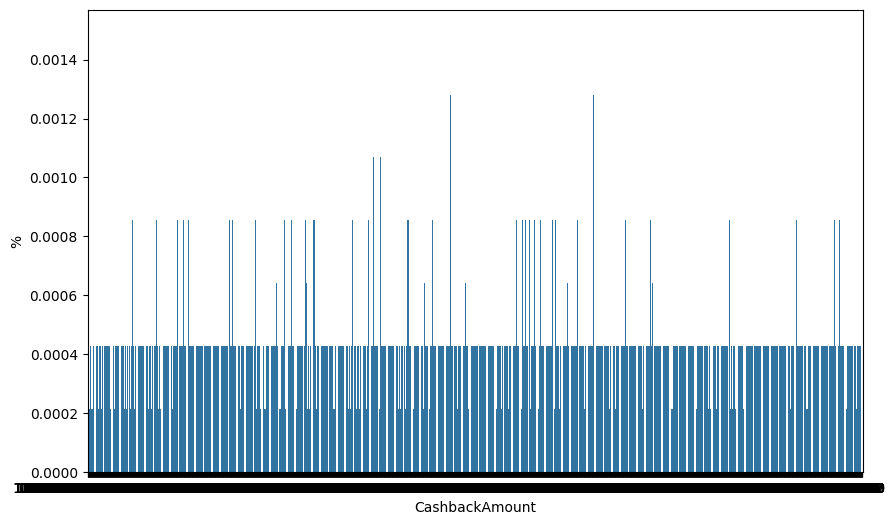

In [99]:
cate_visualize('CashbackAmount',0)

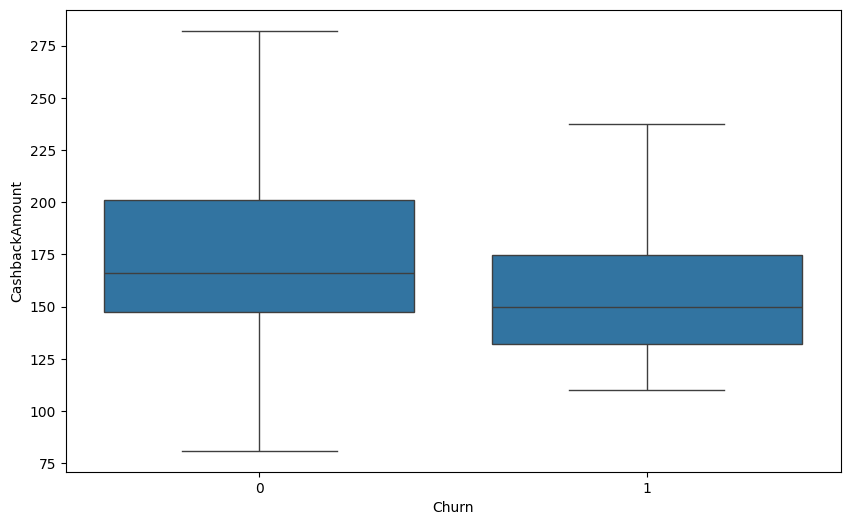

In [100]:
numeric_visualize('CashbackAmount',False)

Người dùng rời bỏ nhận được số tiền hoàn lại ít hơn so với người dùng không rời bỏ.

→ Sử dụng tính năng này cho mô hình

**1.3.3 Conclusion after EDA**

**Sau khi review tất cả các features, chúng ta có các insight sau:**

- Người dùng rời bỏ thường là người dùng mới
- Khách hàng thích mua Mobile Phone hơn
- Khách hàng thường ở tình trạng độc thân
- Khách hàng có những phàn nàn về dịch vụ
- Khách hàng nhận được số tiền hoàn lại ít hơn những người khác

**Chúng ta có một số suggestions để giúp công ty giảm số lượng khách hàng rời bỏ:**
- Liên hệ với những khách phàn nàn, khắc phục những vấn đề họ gặp phải và tặng họ voucher hoặc ưu đãi đặc biệt
- Có những chương trình ưu đãi đặc biệt hoặc giảm giá dành cho người dùng mới, những cặp đôi, nhóm bạn...Những chiến dịch nên được làm theo các dịp đặc biệt trong năm.
- Đề xuất, quảng cáo nhiều sản phẩm hơn nữa trên các trang social hoặc gợi ý sản phẩm cùng phân khúc khi đơn hàng MobiPhone được thanh toán.


**2. FEATURE TRANSFORMING**

Trong trường hợp này chúng ta sẽ sử dụng mô hình Decision Tree và những mô hình khác dựa trên thuật toán của decision tree

→ Đầu tiên tôi sẽ sử dụng tất cả các tính năng của mô hình để đánh giá độ chính xác (accuracy).

**2.1 Encoding**

In [101]:
!pip install pandas
import numpy as np
import pandas as pd

In [102]:
cate_columns = df.loc[:, df.dtypes == object].columns.tolist()
cate_columns

['PreferredLoginDevice',
 'PreferredPaymentMode',
 'Gender',
 'PreferedOrderCat',
 'MaritalStatus']

In [103]:
encoded_df = pd.get_dummies(df, columns = cate_columns,drop_first=True)
encoded_df.shape

(5630, 27)

**2.2 Normalization**


In [104]:
#Scale Feature:
scaler = MinMaxScaler()
model=scaler.fit(encoded_df)
scaled_data=model.transform(encoded_df)

In [105]:
scaled_df = pd.DataFrame(scaled_data, columns = encoded_df.columns.tolist())
scaled_df.drop(columns = 'CustomerID',inplace=True)


In [106]:
scaled_df

,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,...,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1.0,0.065574,1.0,0.008197,0.6,0.4,0.25,0.380952,1.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.147541,0.0,0.024590,0.6,0.6,0.50,0.285714,1.0,0.266667,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.147541,0.0,0.204918,0.4,0.6,0.50,0.238095,1.0,0.200000,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.000000,1.0,0.081967,0.4,0.6,1.00,0.333333,0.0,0.800000,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.000000,0.0,0.057377,0.0,0.4,1.00,0.095238,0.0,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,0.0,0.163934,0.0,0.204918,0.6,0.2,0.00,0.238095,0.0,0.466667,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5626,0.0,0.213115,0.0,0.065574,0.6,0.8,1.00,0.238095,0.0,0.333333,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5627,0.0,0.016393,0.0,0.049180,0.6,0.2,0.75,0.095238,1.0,0.666667,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5628,0.0,0.377049,1.0,0.032787,0.8,0.8,0.75,0.142857,0.0,0.266667,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


**3. Model Training**

**3.1 Slip data into train/test set**

In [107]:
from sklearn.model_selection import train_test_split
x=scaled_df.drop('Churn', axis = 1)
y=scaled_df[['Churn']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

**4. Model Evaluation**


**4.1 Apply model: Logistic Regression**

In [108]:
from sklearn.linear_model import LogisticRegression

clf_logis = LogisticRegression(random_state = 0)
clf_logis.fit(x_train, y_train)

LogisticRegression(random_state=0)

In [109]:
y_pred_test = clf_logis.predict(x_test)
y_pred_train = clf_logis.predict(x_train)

In [110]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)
print(balanced_accuracy_train,balanced_accuracy_test)

0.717935635343012 0.7131334832838748


→ Độ chính xác cân bằng (balanced accuracy) của Logistic Regression là 71% không nằm trong unerfitting hoặc overfitting

Tuy nhiên, chúng tôi chỉ sử dụng Logistic Regression cho linear features. Trong trường hợp này, chúng tôi đang thử tất cả các tính năng trong mô hình nên Logistic Regression không thể phản ánh chính xác dữ liệu.

**4.2 Apply model: Decision Tree**

In [111]:
from sklearn import tree

clf_des = tree.DecisionTreeClassifier()
clf_des.fit(x_train,y_train)

DecisionTreeClassifier()

In [112]:
y_tree_pre_train = clf_des.predict(x_train)
y_tree_pre_test = clf_des.predict(x_test)

In [113]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pre_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.904144011323996


→ Độ chính xác cân bằng (balanced accuracy) của Decision Tree là 89%. Trong trường hợp này là overfitting

Vì mô hình Decision Tree là overfitting nên thay vào đó chúng tôi sẽ thử rừng ngẫu nhiên.

**4.3 Apply model: Random Forest**

In [114]:
from sklearn.ensemble import RandomForestClassifier

clf_rand = RandomForestClassifier(max_depth=2, random_state=0)

clf_rand.fit(x_train, y_train)
y_ranf_pre_train = clf_rand.predict(x_train)
y_ranf_pre_test = clf_rand.predict(x_test)

In [115]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_tree_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_tree_pre_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.904144011323996


→ Độ chính xác cân bằng (balanced accuracy) của Random Forest là 90%. Trong trường hợp này là overfitting

**4.4 Enhanced Random Forest model**

Show the Feature Importances:

In [116]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x_test.columns, clf_rand.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=True)

importances = importances.reset_index()

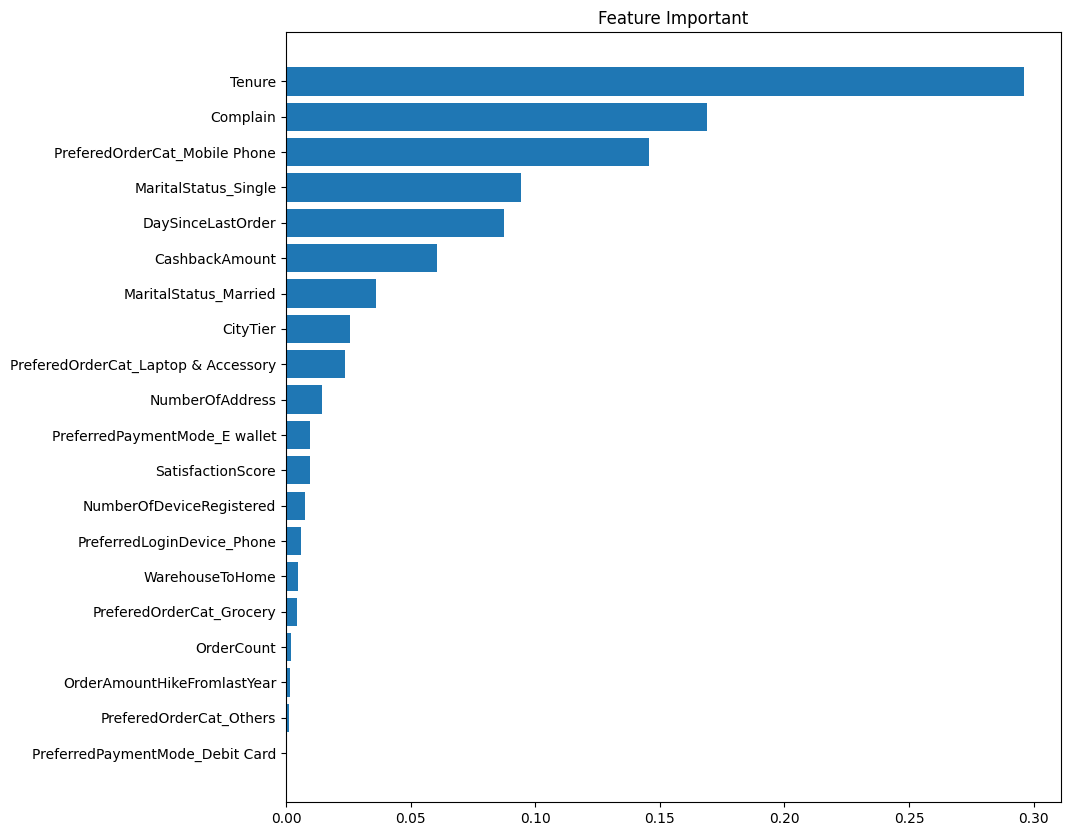

In [117]:
# Create bar chart
plt.figure(figsize=(10, 10))
plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

plt.title('Feature Important')

# Show plot
plt.show()

The model lấy Tenure và Complain làm 2 features quan trọng nhất

→ Make sense with the features that we EDA in below

**Hyperparameter Tuning**

We will go through all hyperparameters of Random Forest model to define with hyperparameters will bring the best balanced_accuracy for the data

In [118]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(clf_rand, param_grid, cv=5, scoring='balanced_accuracy')


In [119]:
# Fit the model
grid_search.fit(x_train, y_train)
/
# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
accuracy = best_clf.score(x_test, y_test)
print("Test set accuracy: ", accuracy)

KeyboardInterrupt: 

In [120]:
#Apply best hyperparameter model to the data:

from sklearn import tree

clf_rand_tun = RandomForestClassifier(
    n_estimators= 100,
    max_depth= 20,
    min_samples_split= 2,
    min_samples_leaf= 1,
    bootstrap= False)

clf_rand_tun.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=20)

In [121]:
y_rand_tun_train = clf_rand_tun.predict(x_train)
y_rand_tun_test = clf_rand_tun.predict(x_test)

In [122]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_rand_tun_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_rand_tun_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.9182948061248706


In [123]:
y_rand_tun_proba = clf_rand_tun.predict_proba(x_test)[:,1]
y_rand_tun_proba

array([1.  , 0.  , 0.  , ..., 0.07, 0.1 , 0.99])

**Probability Threshold selection**

As default, model will get probability threshold = 0.5 for the model. If we change the probability threshold, the accuracy of model can improve? We will use ROC curve to check which probability threshold will have highest True Positive Rate and loweest False Positive rate

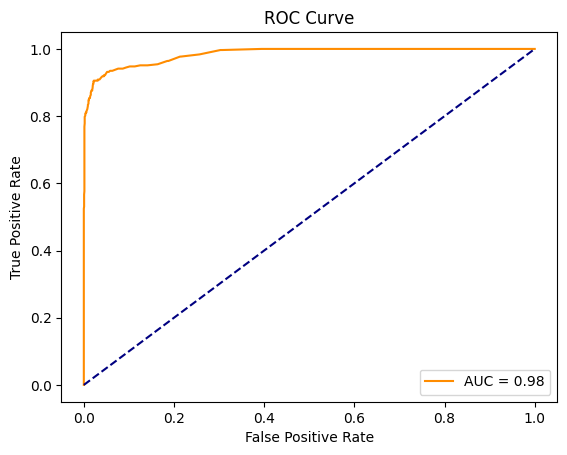

In [124]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


fpr, tpr, thresholds = roc_curve(y_test, y_rand_tun_proba)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [129]:
# Calculate the distance for each threshold
distances = np.sqrt((0 - fpr)**2 + (1 - tpr)**2)
# Get the threshold for the smallest distance
best_threshold = thresholds[np.argmin(distances)]
print(f"Best threshold: {best_threshold}")

Best threshold: 0.21


In [128]:
threshold = 0.21

y_pred_prod = (y_rand_tun_proba > threshold).astype(int)

balanced_accuracy = balanced_accuracy_score(y_test, y_pred_prod)
print("Test balanced accurary :", round(balanced_accuracy,5))

Test balanced accurary : 0.93836


After hyperparameter tuning & probability threshold selecition, we will choose the model Random Forest with the hyperparameter as below and the probability = 0.21.

*   n_estimators= 100,
*   max_depth= 20,
*   min_samples_split= 2,
*   min_samples_leaf= 1,
*   bootstrap= False

